In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, silhouette_score

import xgboost as xgb

# Setting pandas options
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
df = pd.read_csv('diabetic_data.csv')
print(df.head())
print(df.info())

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

In [ ]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'Cluster'],
      dtype='object')

In [ ]:
missing_values = df.isin(['?']).sum()
print("Missing values:\n", missing_values[missing_values > 0])

Missing values:
 race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64


In [ ]:
df = df.replace('?', np.nan)

In [ ]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(exclude=[np.number]).columns

numeric_imputer = SimpleImputer(strategy='median')
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

In [ ]:
def custom_gender_count(x):
    return sum(1 for i in x if i in ['Male', 'Female', 'Unknown/Invalid'])

gender_counts = df['gender'].apply(custom_gender_count)
print("Gender counts:", gender_counts.value_counts())

gender_map = {'Male': 'Male', 'Female': 'Female'}
df['gender'] = df['gender'].map(gender_map).fillna('Unknown')

Gender counts: gender
0    101766
Name: count, dtype: int64


In [ ]:
df['readmitted'] = df['readmitted'].map({'NO': 0, '<30': 1, '>30': 1})

In [ ]:
le = LabelEncoder()
for col in categorical_columns:
    if col != 'readmitted':
        df[col] = le.fit_transform(df[col])

In [ ]:
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

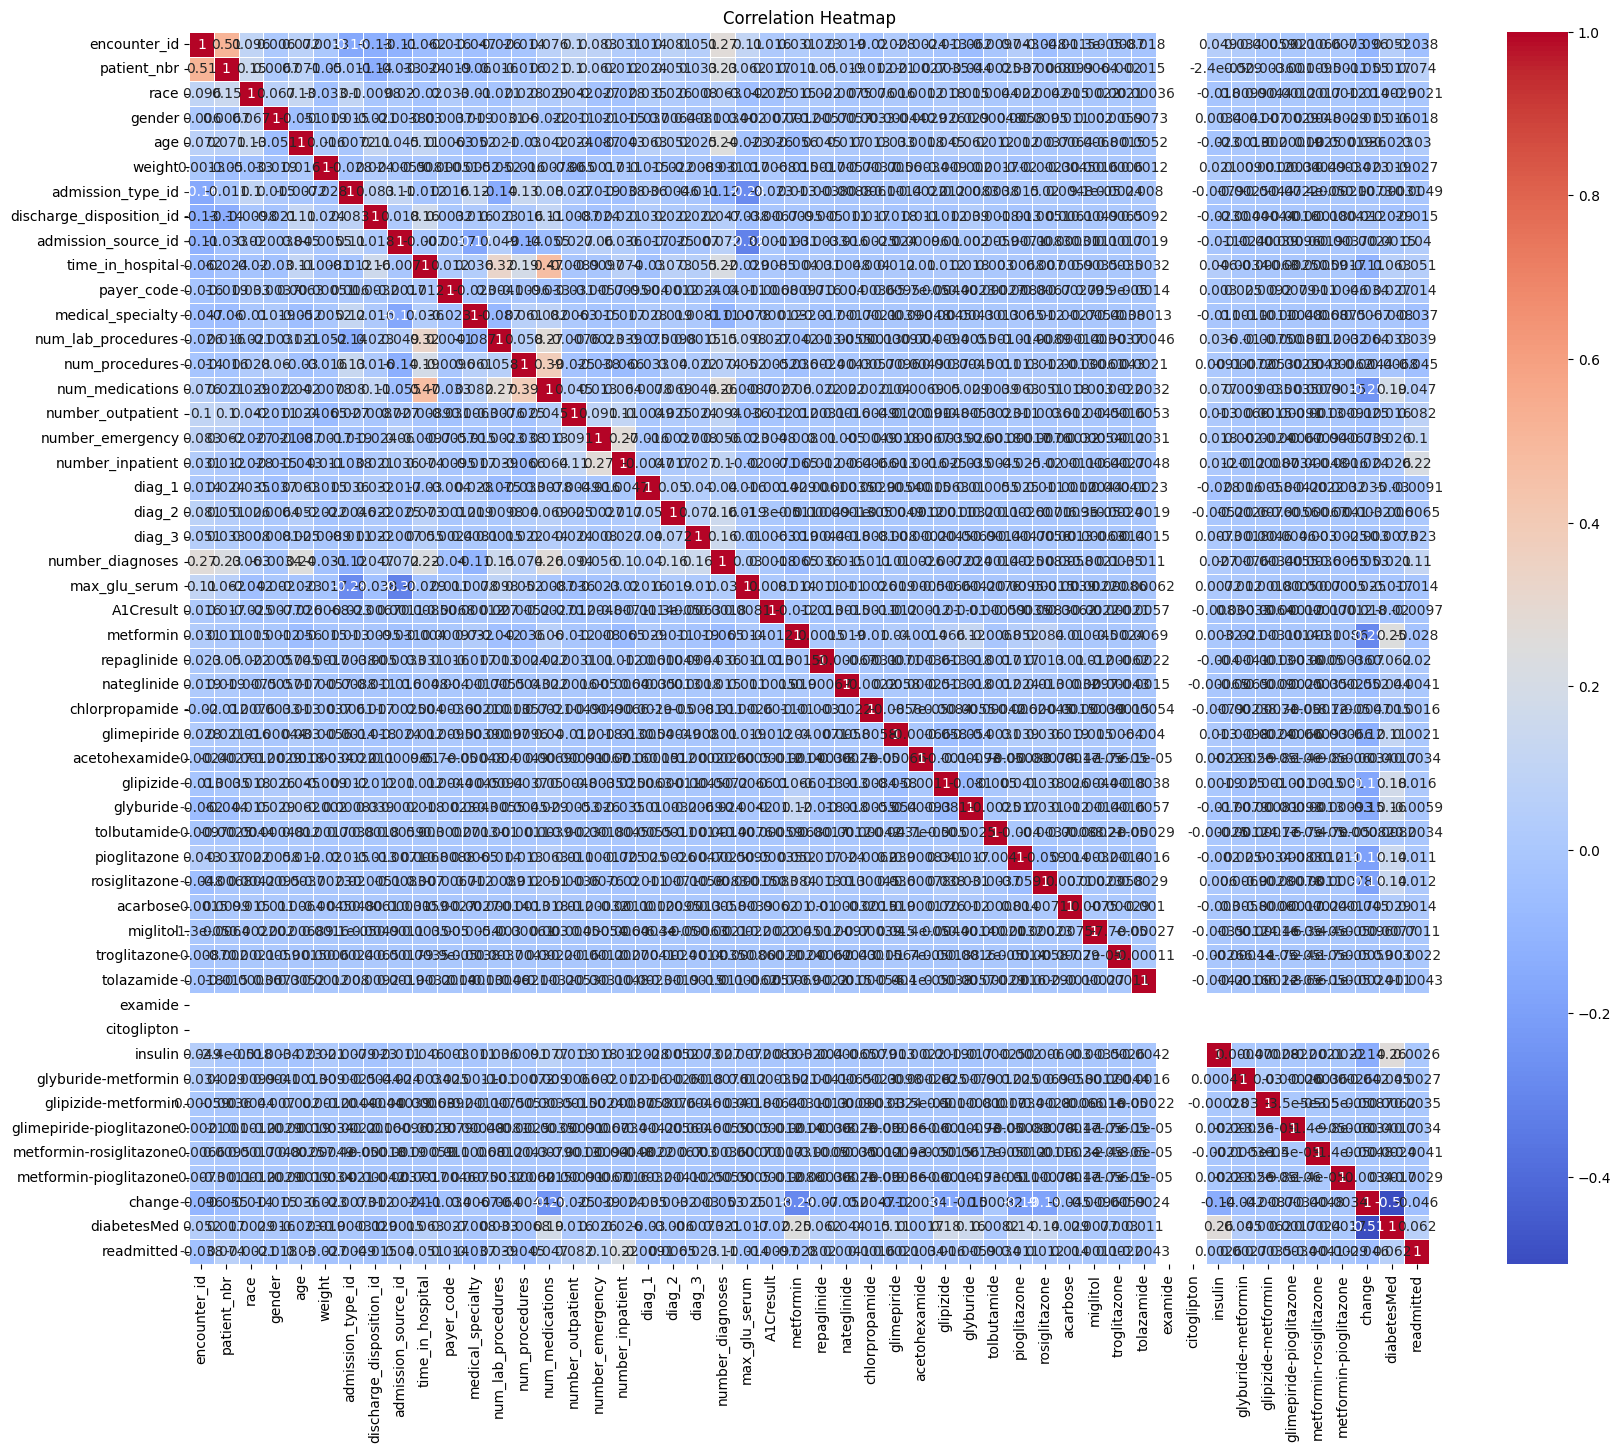

In [ ]:
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
X = df.drop('readmitted', axis=1)
y = df['readmitted']

selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

Selected features: ['patient_nbr', 'time_in_hospital', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'change', 'diabetesMed']


C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [39 40] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_selected)
print("Number of components after PCA:", pca.n_components_)

Number of components after PCA: 8


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.66      0.64     10952
           1       0.57      0.52      0.54      9402

    accuracy                           0.60     20354
   macro avg       0.59      0.59      0.59     20354
weighted avg       0.59      0.60      0.59     20354



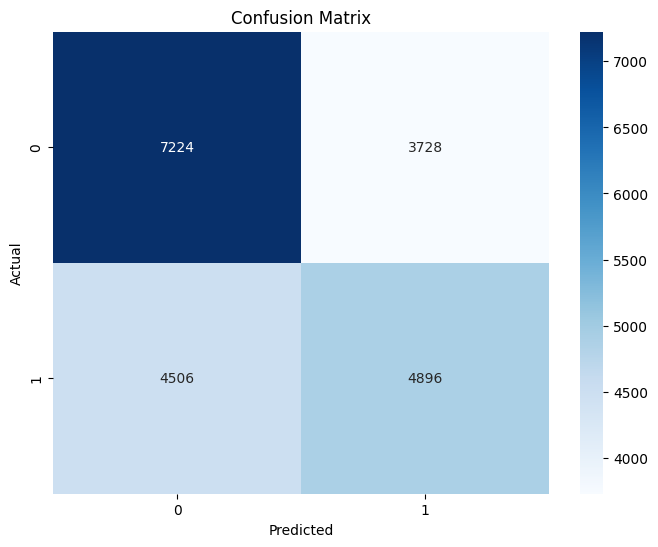

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

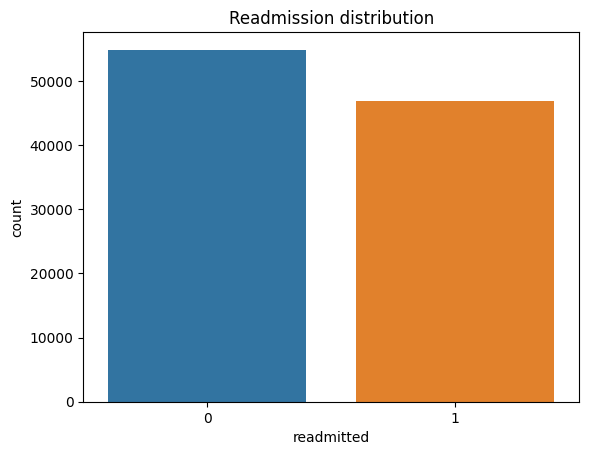

In [ ]:
sns.countplot(x = "readmitted", data = df)
plt.title("Readmission distribution")
plt.show()

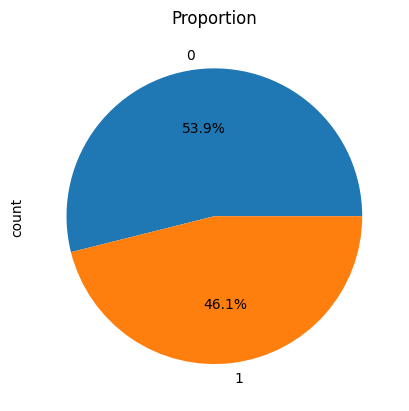

In [ ]:
df.readmitted.value_counts().plot.pie(autopct = "%.1f%%")
plt.title("Proportion")
plt.show()

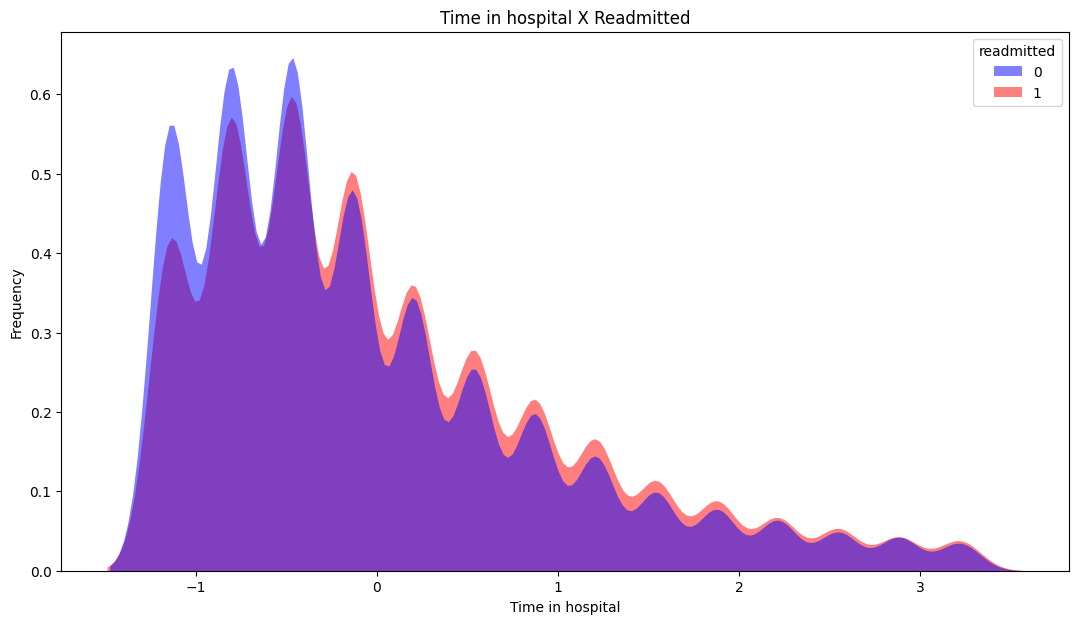

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))

sns.kdeplot(data=df, x='time_in_hospital', hue='readmitted', fill=True, common_norm=False, palette=['b', 'r'],
            alpha=.5, linewidth=0)

ax.set(xlabel='Time in hospital', ylabel='Frequency')
plt.title('Time in hospital X Readmitted')

plt.show()

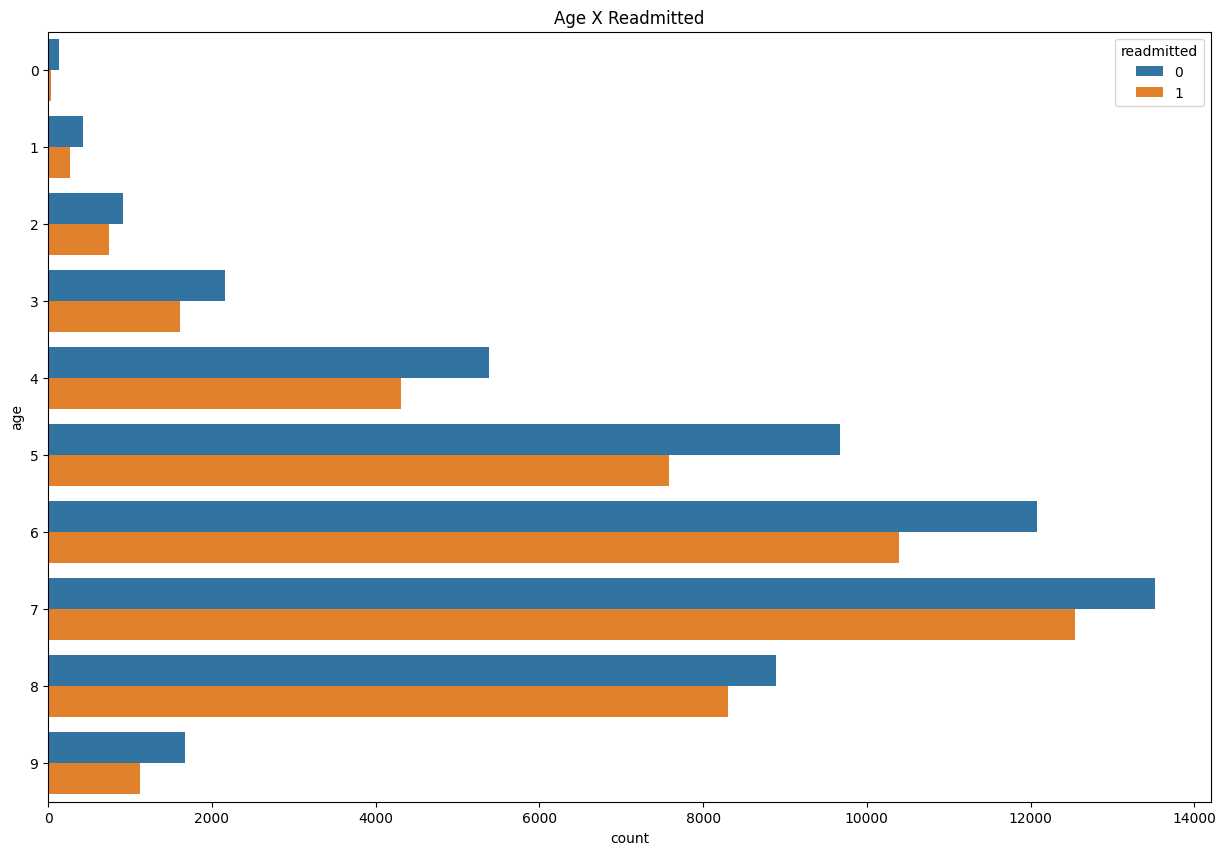

In [ ]:
plt.figure(figsize=(15, 10))
sns.countplot(y=df['age'], hue=df['readmitted'])
plt.title('Age X Readmitted')
plt.show()

<Axes: xlabel='count', ylabel='race'>

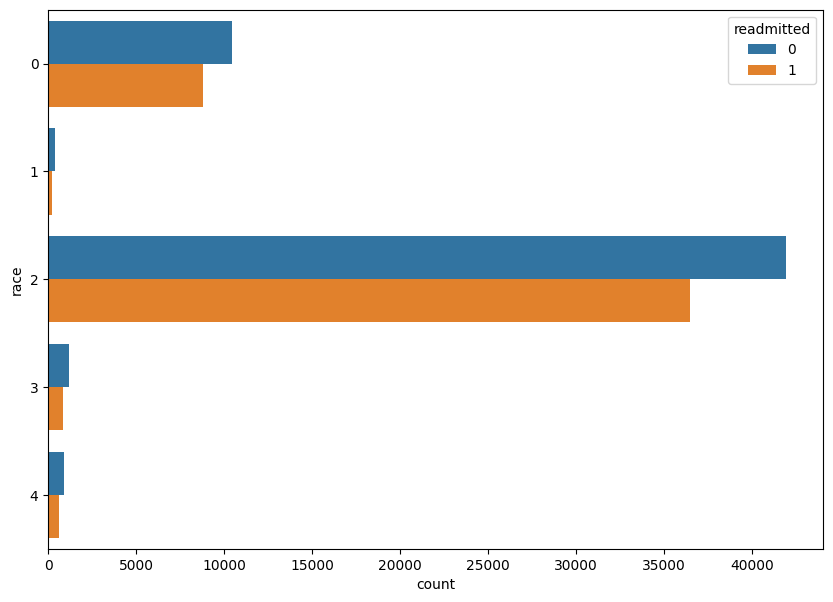

In [ ]:
fig = plt.figure(figsize=(10,7))
sns.countplot(y = df['race'], hue = df['readmitted'])

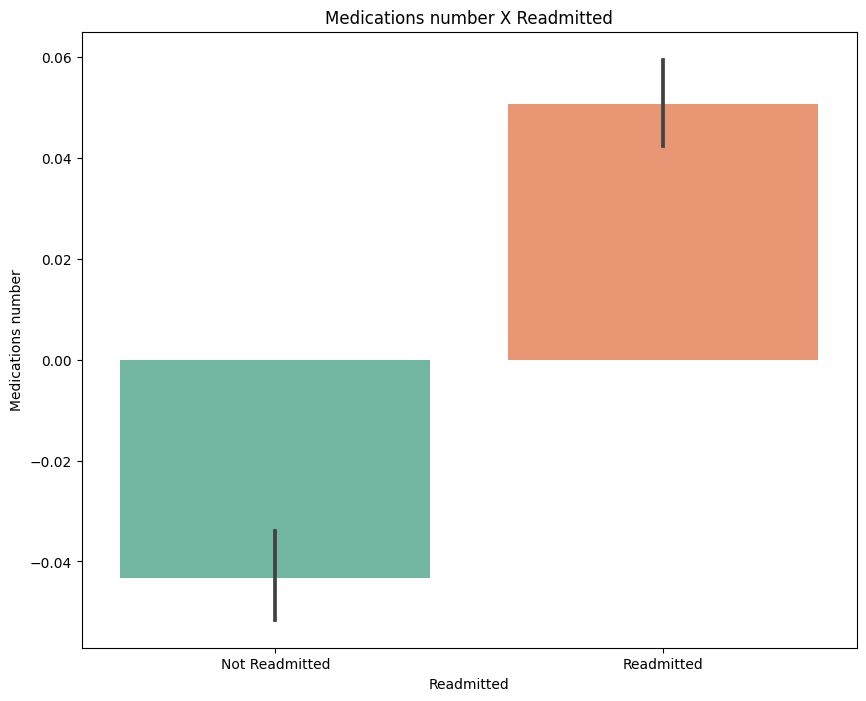

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x=df['readmitted'], y=df['num_medications'], palette='Set2')
plt.title("Medications number X Readmitted")
plt.xlabel("Readmitted")
plt.ylabel("Medications number")
plt.xticks(ticks=[0, 1], labels=['Not Readmitted', 'Readmitted'])
plt.show()

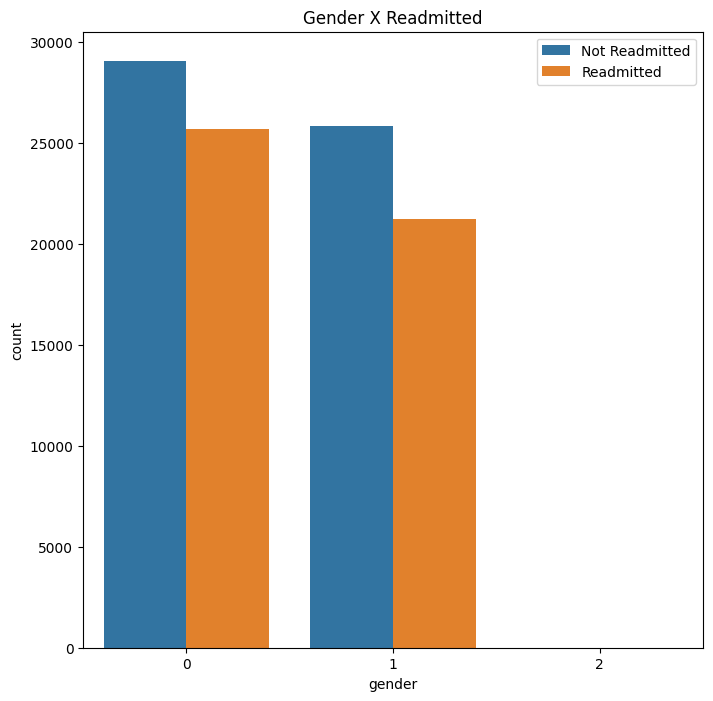

In [ ]:
plt.figure(figsize=(8, 8))
sns.countplot(x=df['gender'], hue=df['readmitted'])
plt.title("Gender X Readmitted")
plt.legend(['Not Readmitted', 'Readmitted'])
plt.show()

Text(0.5, 1.0, 'Medication Change X Readmitted')

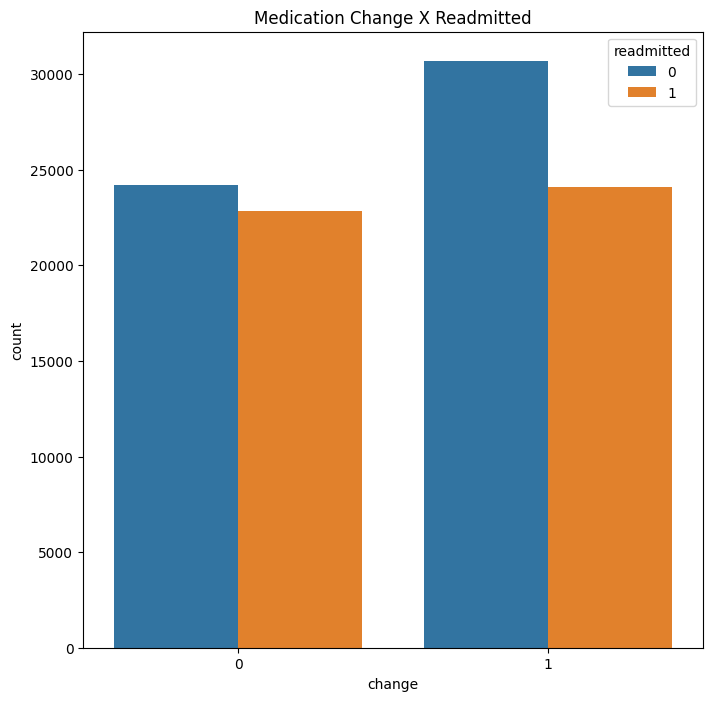

In [ ]:
df['change'] = df['change'].replace({0: 0, 1: 1})
fig = plt.figure(figsize=(8,8))
sns.countplot(x=df['change'], hue=df['readmitted'])
plt.title('Medication Change X Readmitted')

Text(0.5, 1.0, 'Glucose test serum test result VS. Readmission')

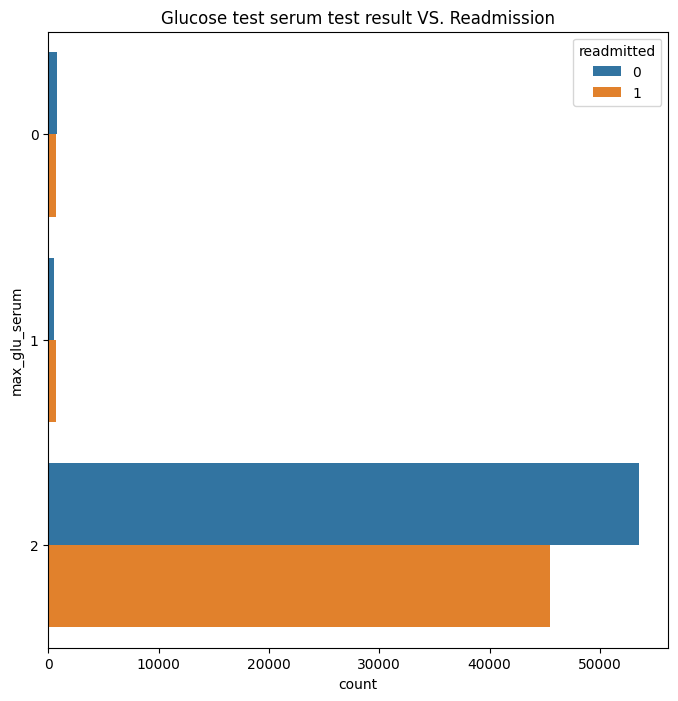

In [ ]:
fig = plt.figure(figsize=(8,8))
sns.countplot(y = df['max_glu_serum'], hue = df['readmitted']).set_title('Glucose test serum test result VS. Readmission')

Text(0.5, 1.0, 'A1C test result VS. Readmission')

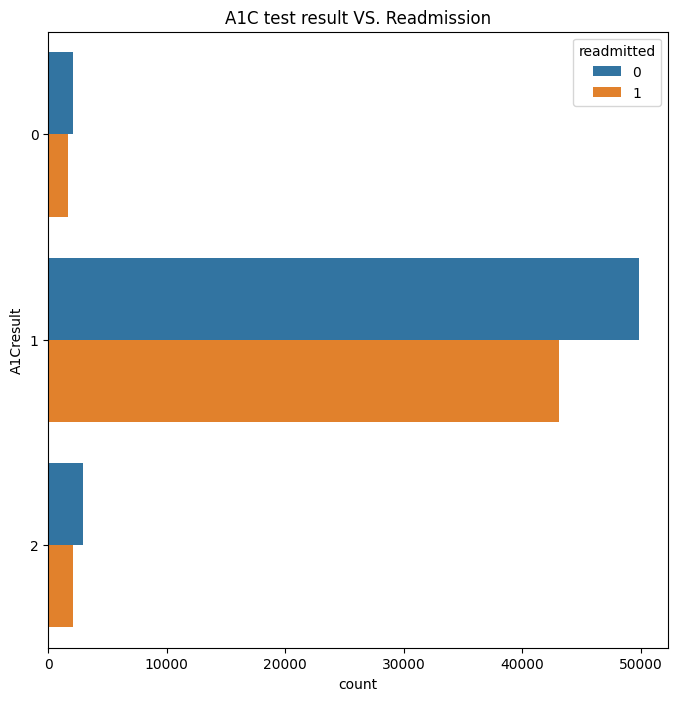

In [ ]:
fig = plt.figure(figsize=(8,8))
sns.countplot(y= df['A1Cresult'], hue = df['readmitted']).set_title('A1C test result VS. Readmission')

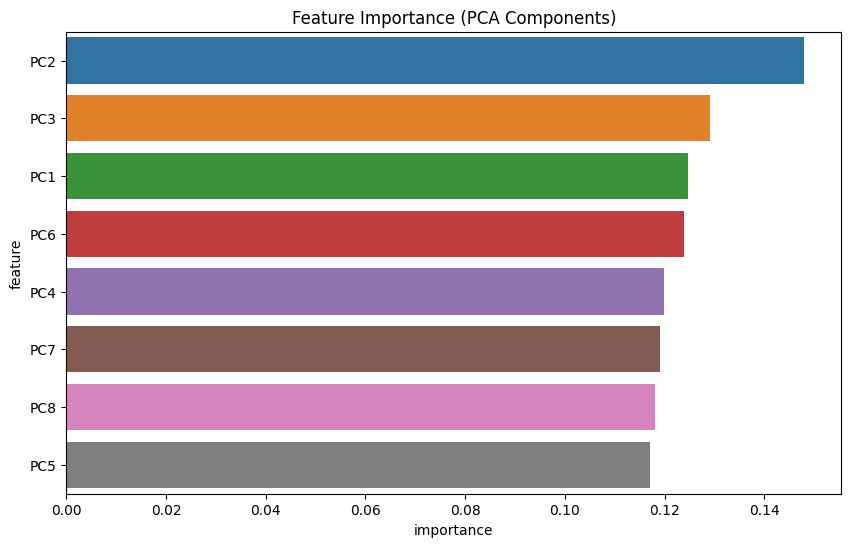

In [ ]:
n_components = rf_model.n_features_in_
feature_names = [f"PC{i+1}" for i in range(n_components)]

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (PCA Components)')
plt.show()

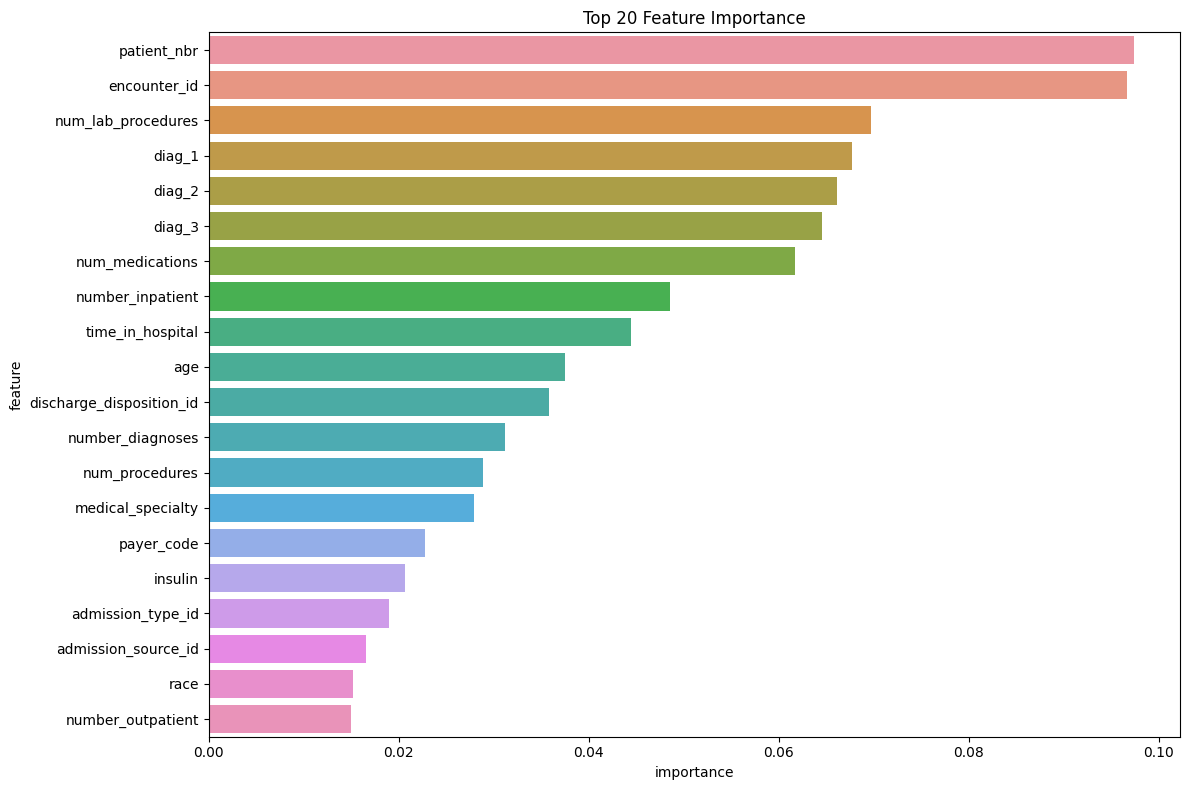

Top 20 important features:
                     feature  importance
1                patient_nbr    0.097366
0               encounter_id    0.096686
12        num_lab_procedures    0.069669
18                    diag_1    0.067721
19                    diag_2    0.066166
20                    diag_3    0.064538
14           num_medications    0.061735
17          number_inpatient    0.048574
9           time_in_hospital    0.044474
4                        age    0.037542
7   discharge_disposition_id    0.035822
21          number_diagnoses    0.031153
13            num_procedures    0.028872
11         medical_specialty    0.027930
10                payer_code    0.022787
41                   insulin    0.020702
6          admission_type_id    0.019015
8        admission_source_id    0.016509
2                       race    0.015188
15         number_outpatient    0.014941


In [ ]:
X_original = df.drop('readmitted', axis=1)
y = df['readmitted']

rf_model_original = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_original.fit(X_original, y)

feature_importance = pd.DataFrame({
    'feature': X_original.columns,
    'importance': rf_model_original.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()

print("Top 20 important features:")
print(feature_importance.head(20))

In [ ]:
X_train_original, X_test_original, y_train, y_test = train_test_split(X_original, y, test_size=0.2, random_state=42)
rf_model_original.fit(X_train_original, y_train)
y_pred_original = rf_model_original.predict(X_test_original)
print(classification_report(y_test, y_pred_original))

              precision    recall  f1-score   support

           0       0.67      0.74      0.70     10952
           1       0.65      0.57      0.61      9402

    accuracy                           0.66     20354
   macro avg       0.66      0.65      0.65     20354
weighted avg       0.66      0.66      0.66     20354



In [ ]:
# Final data quality check
print(df.isnull().sum())
print(df.describe())

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

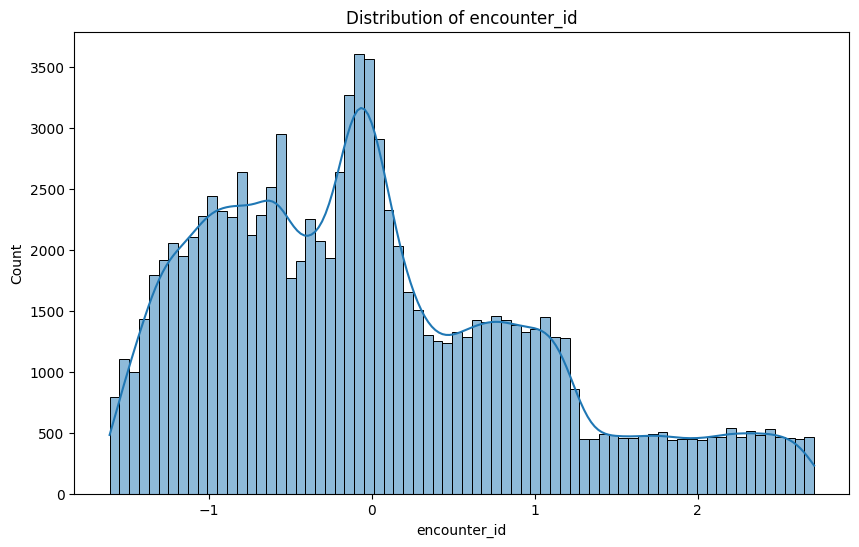

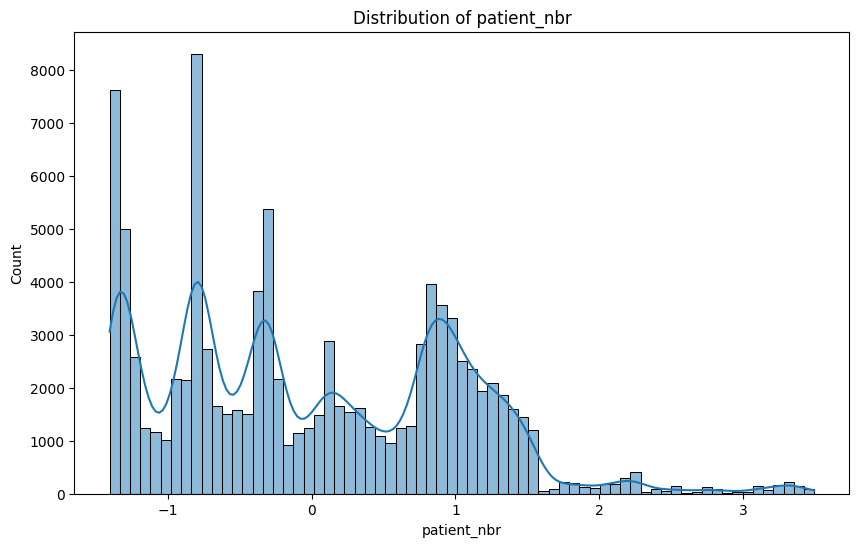

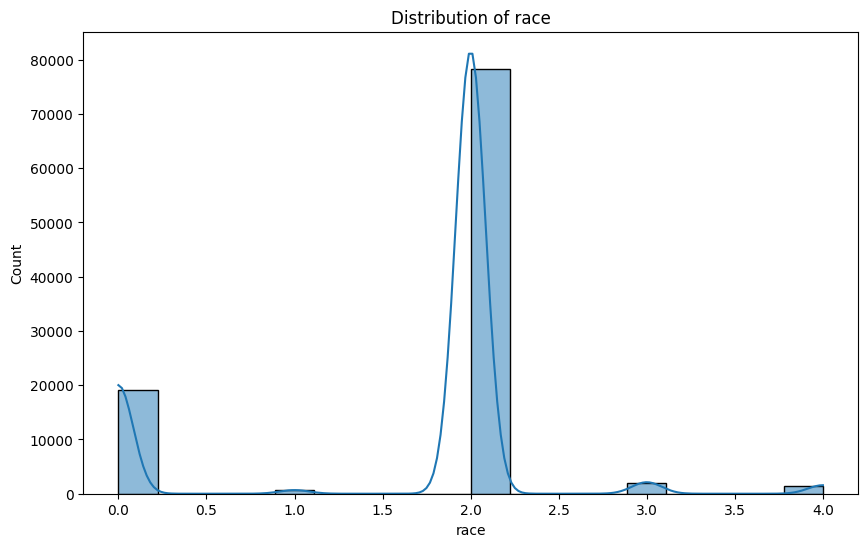

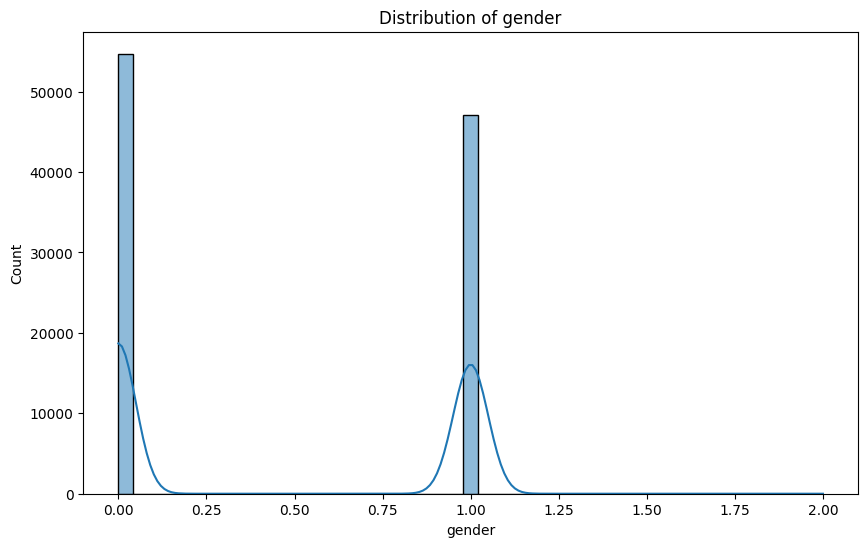

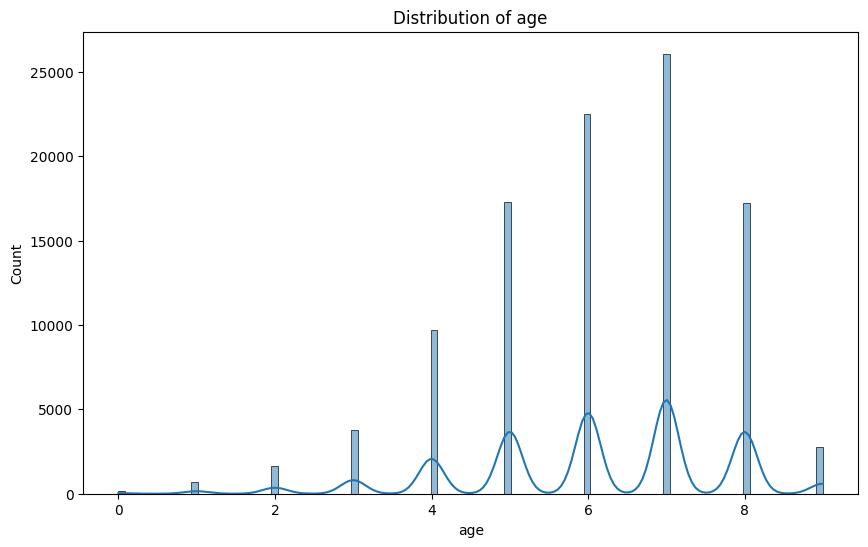

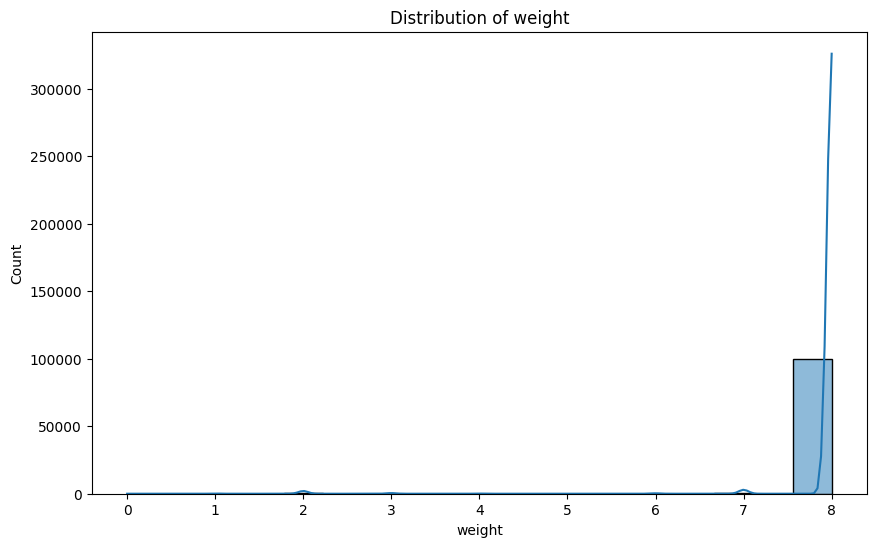

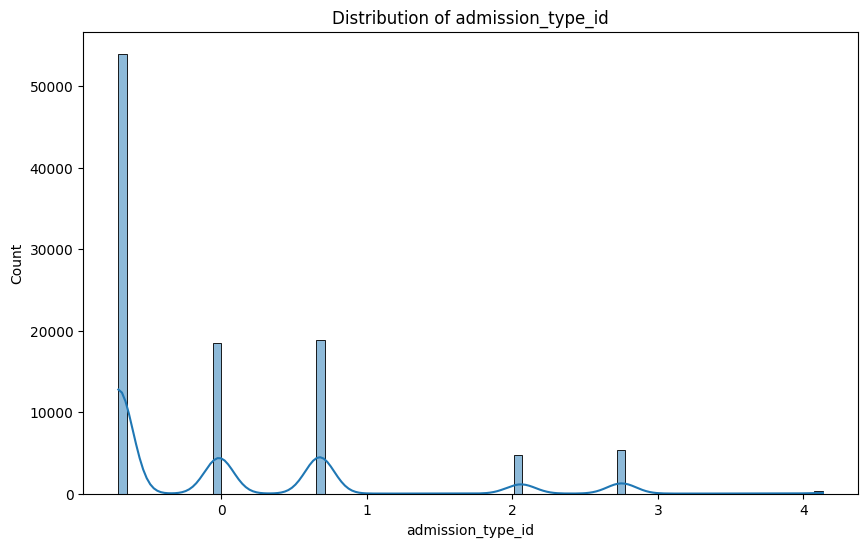

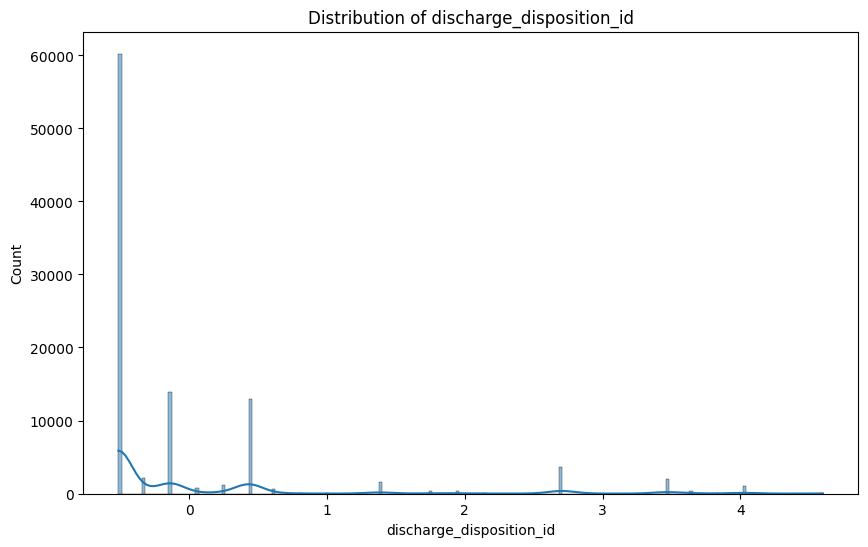

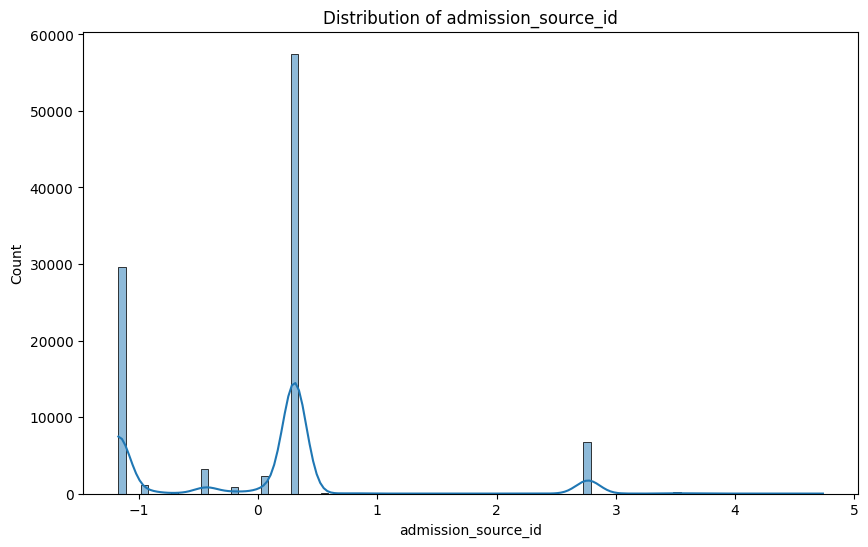

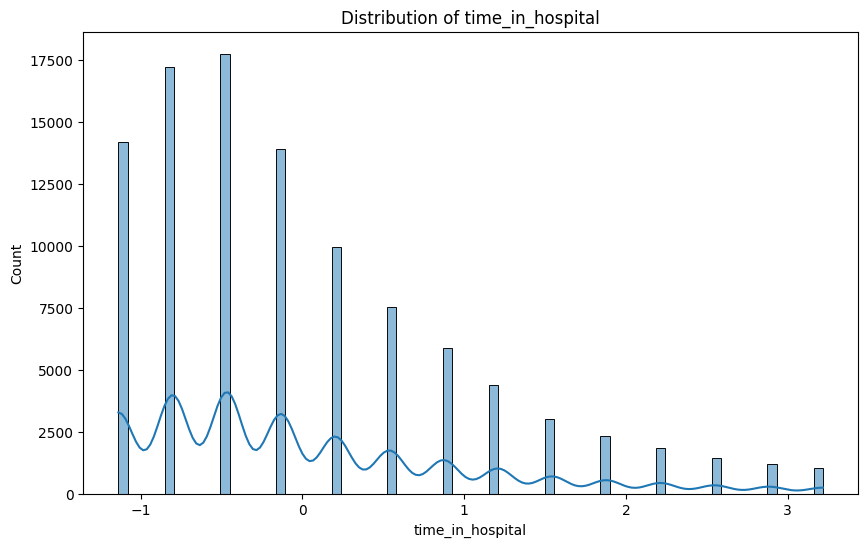

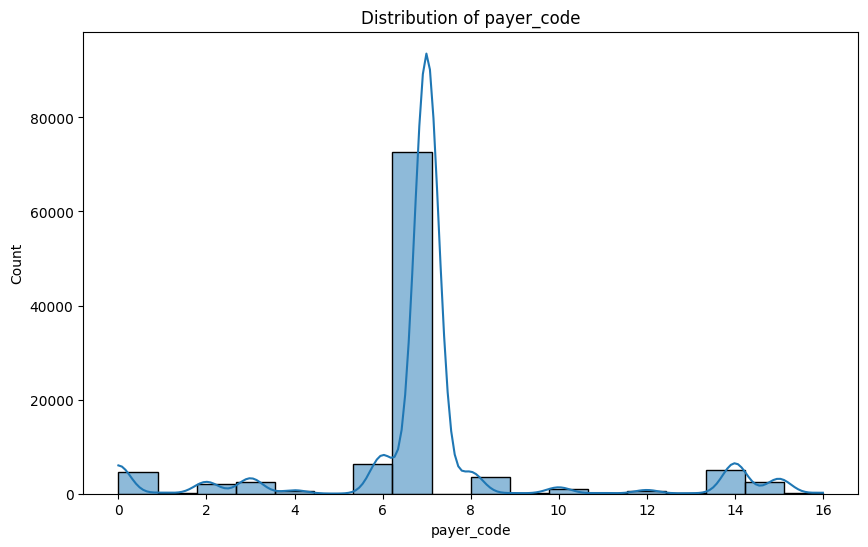

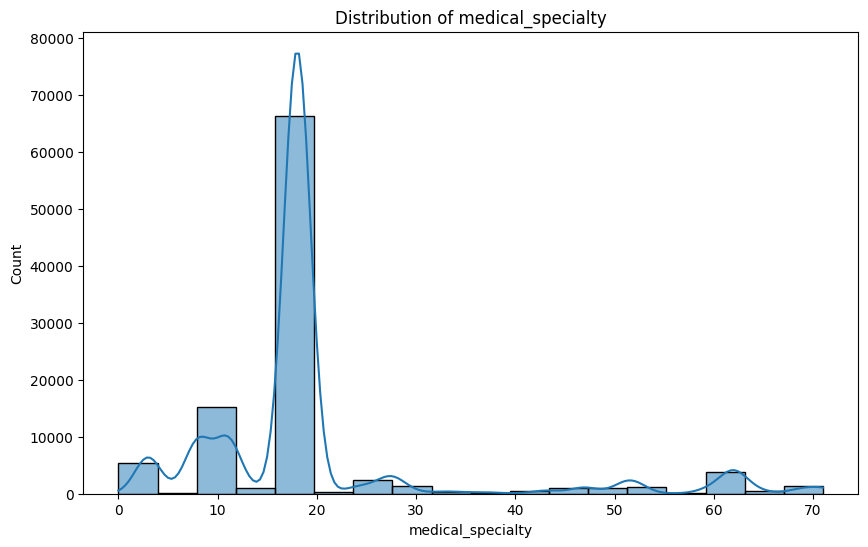

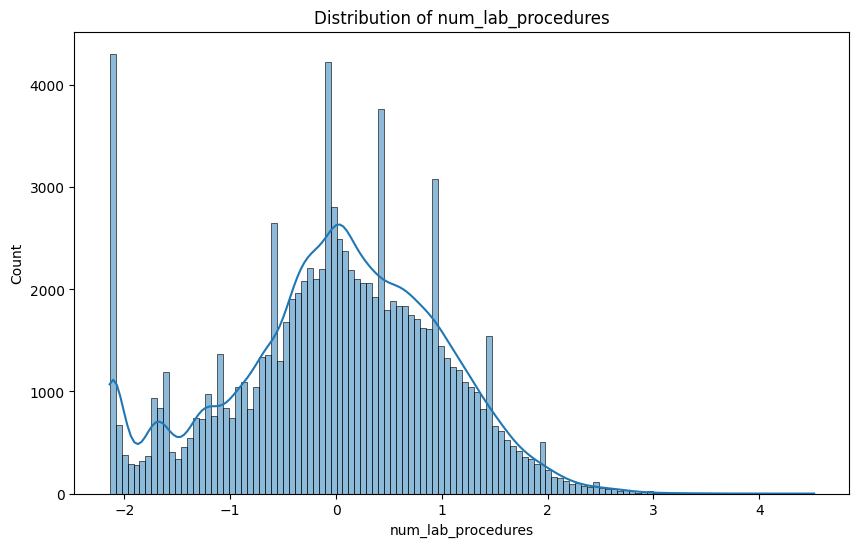

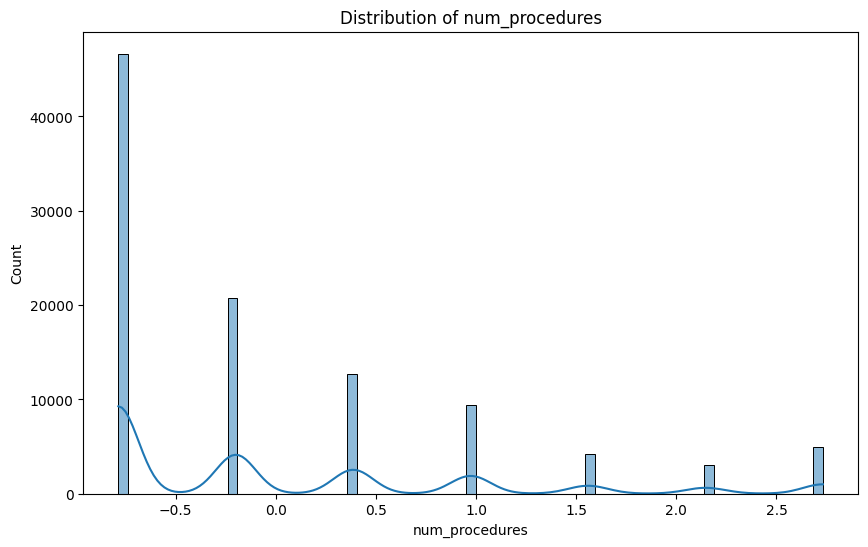

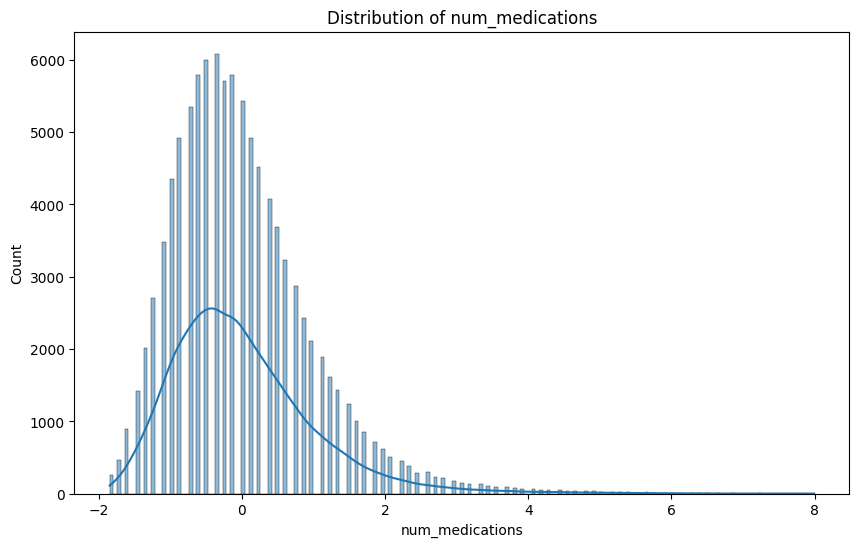

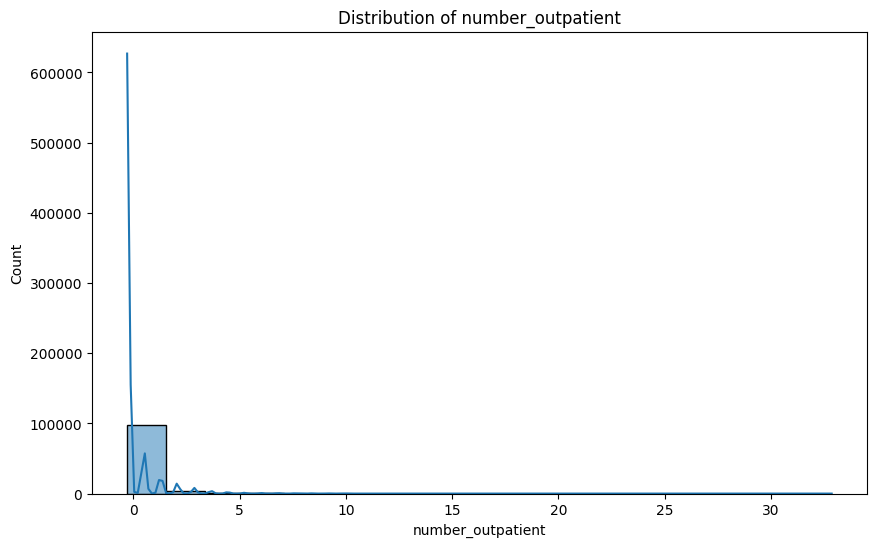

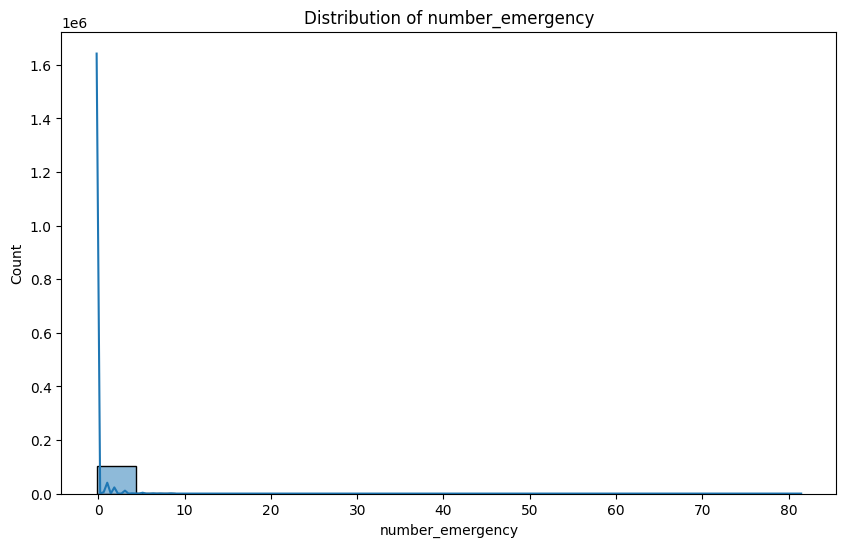

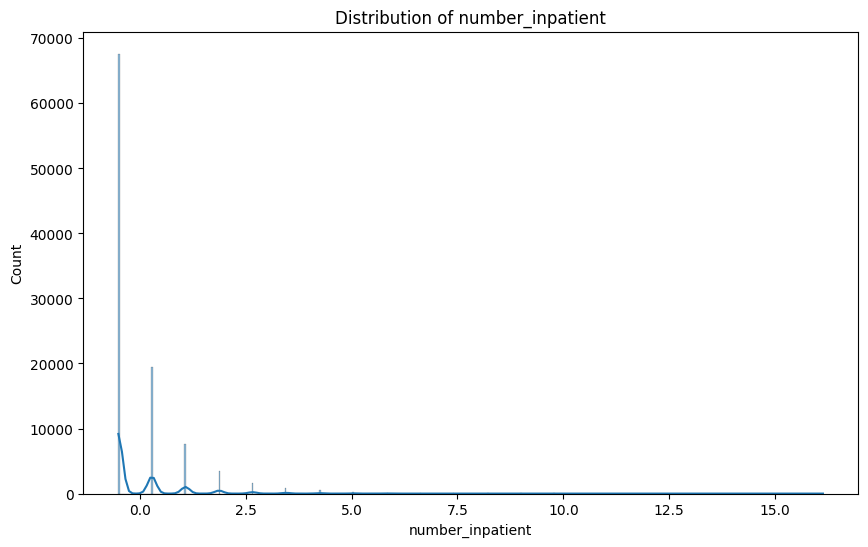

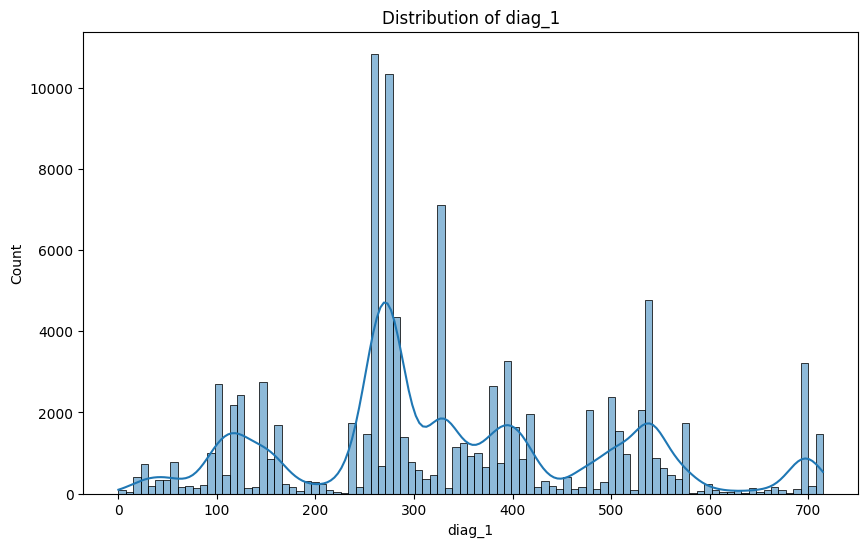

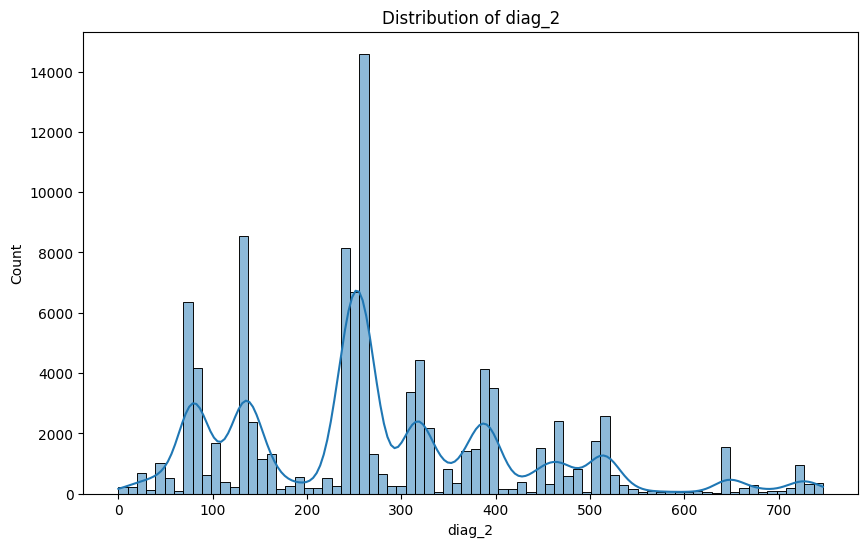

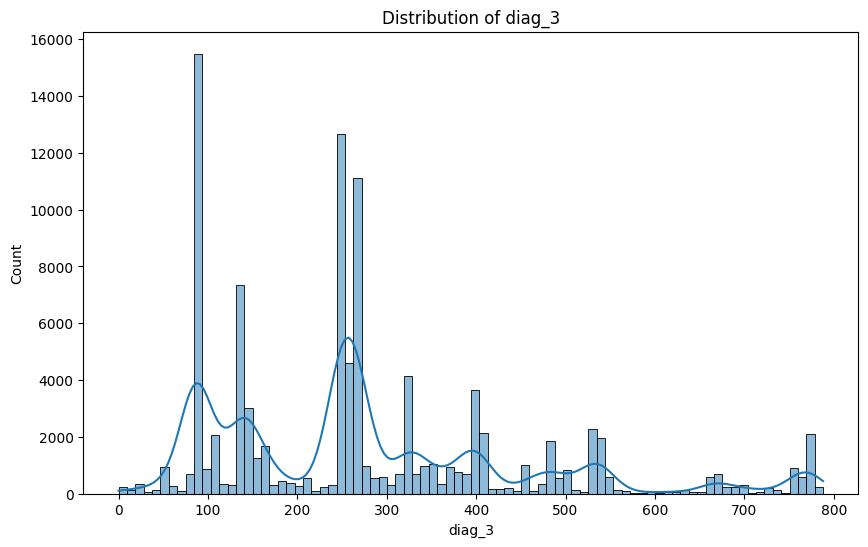

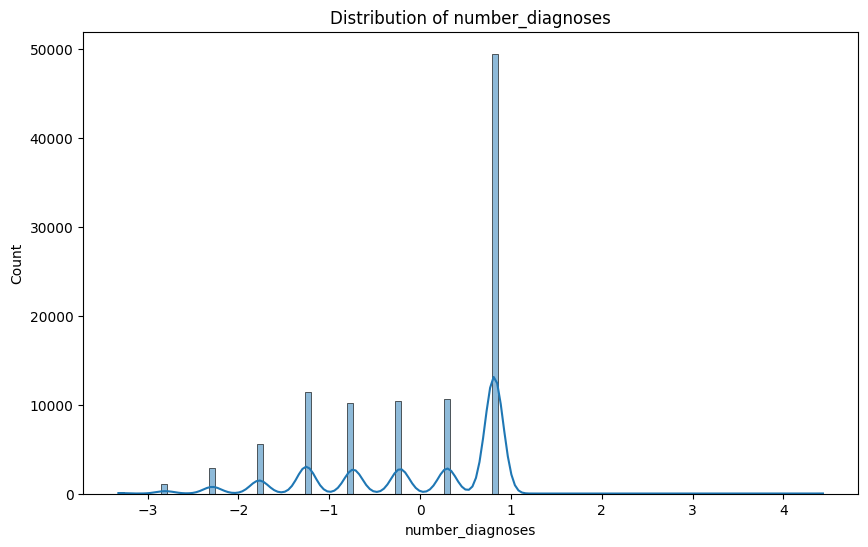

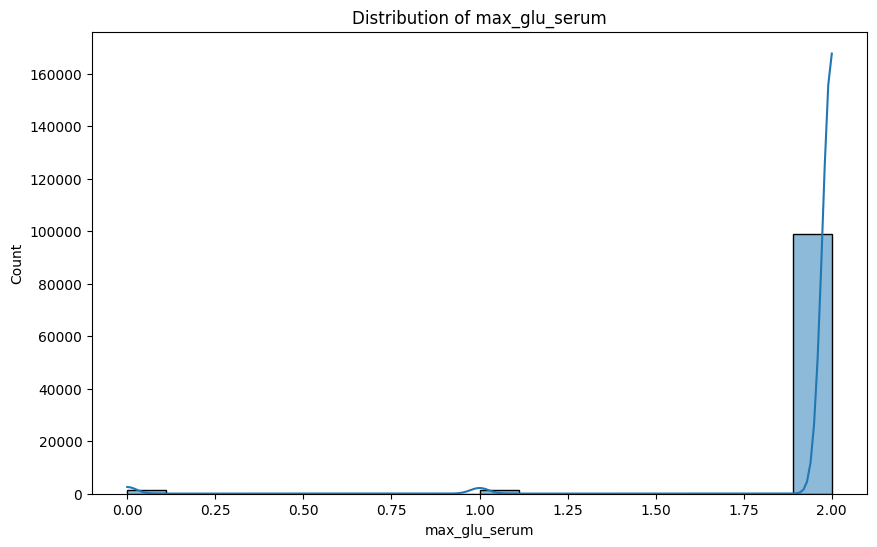

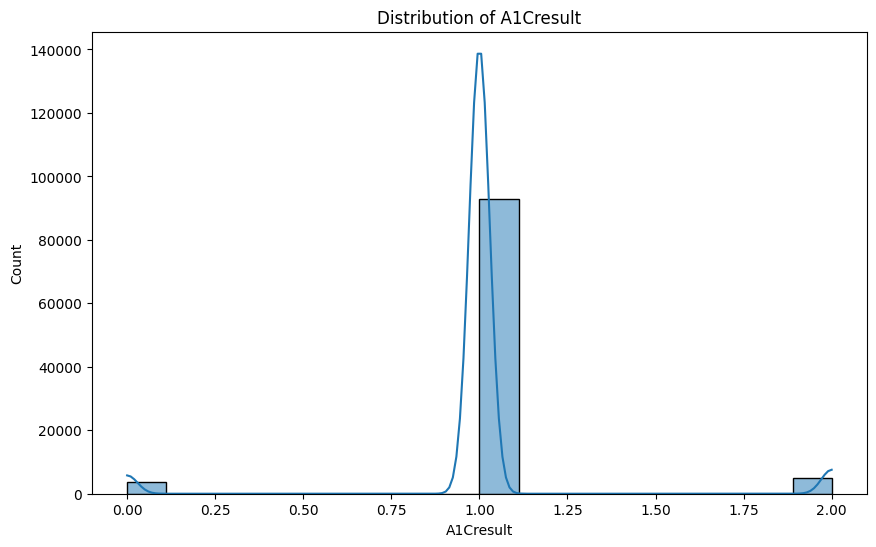

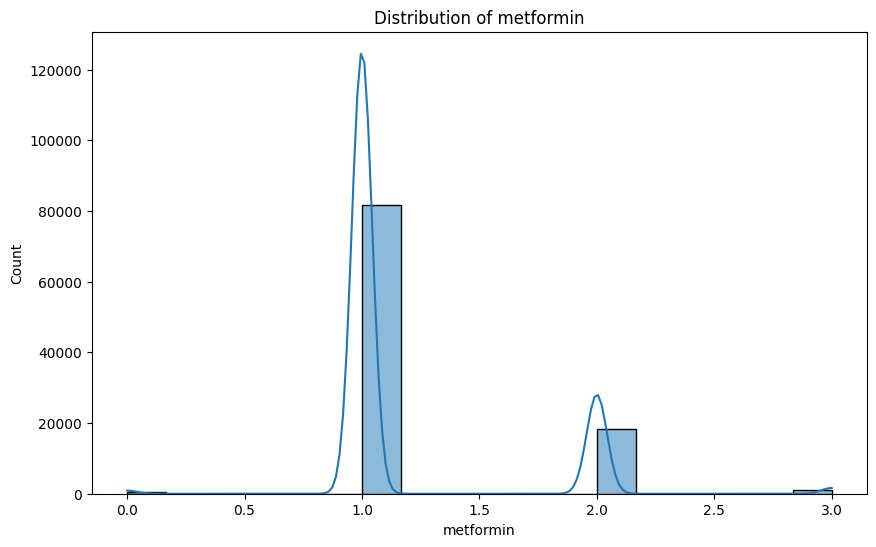

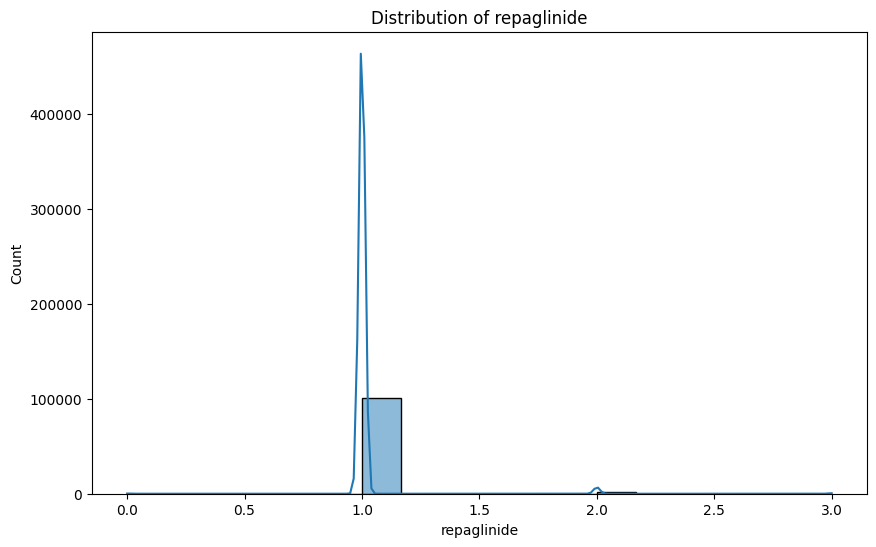

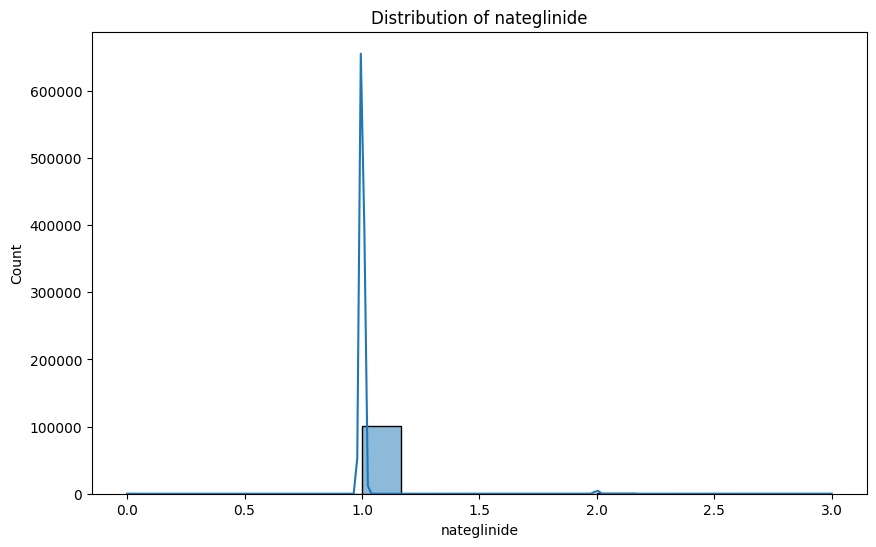

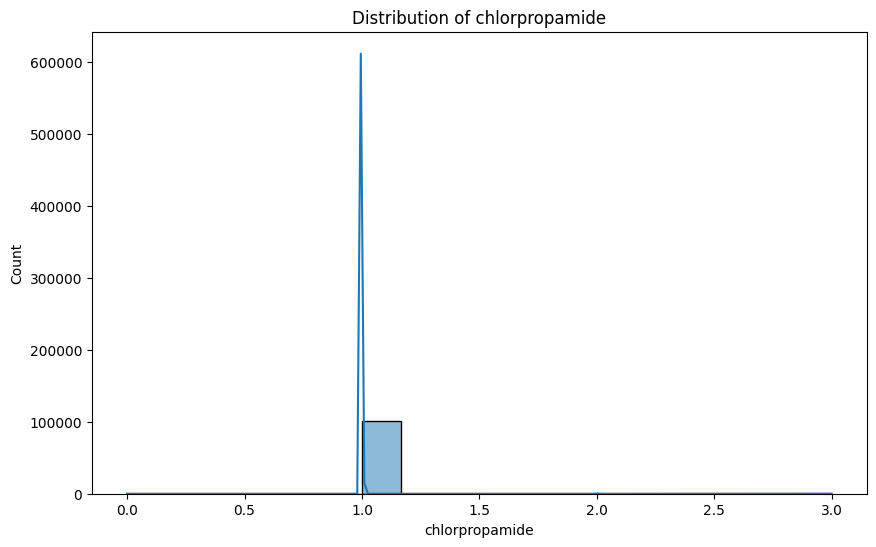

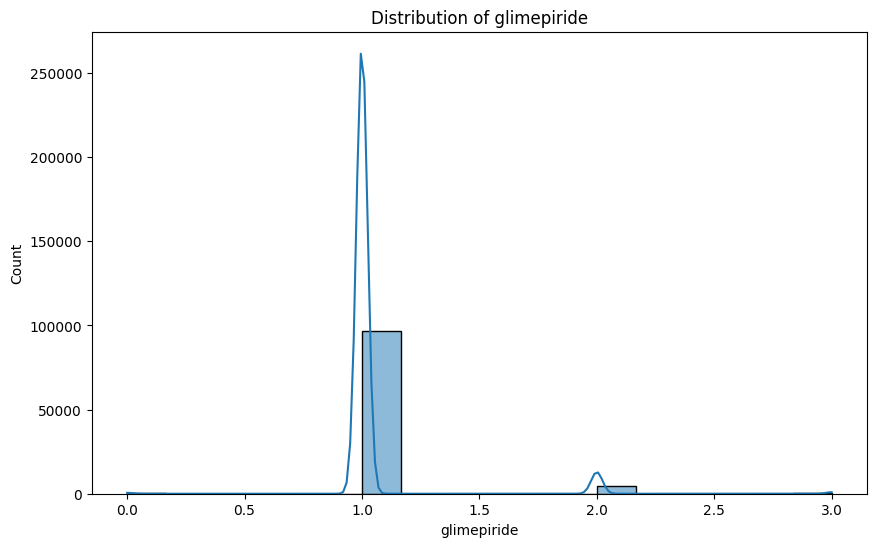

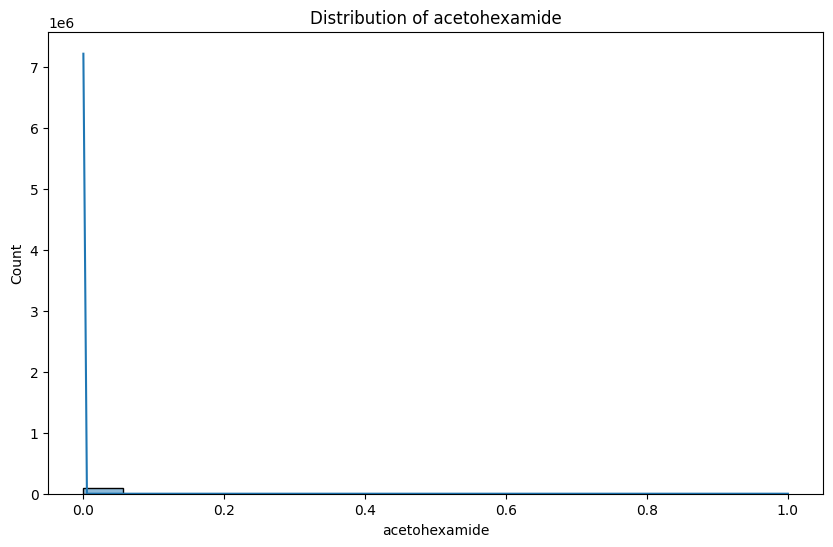

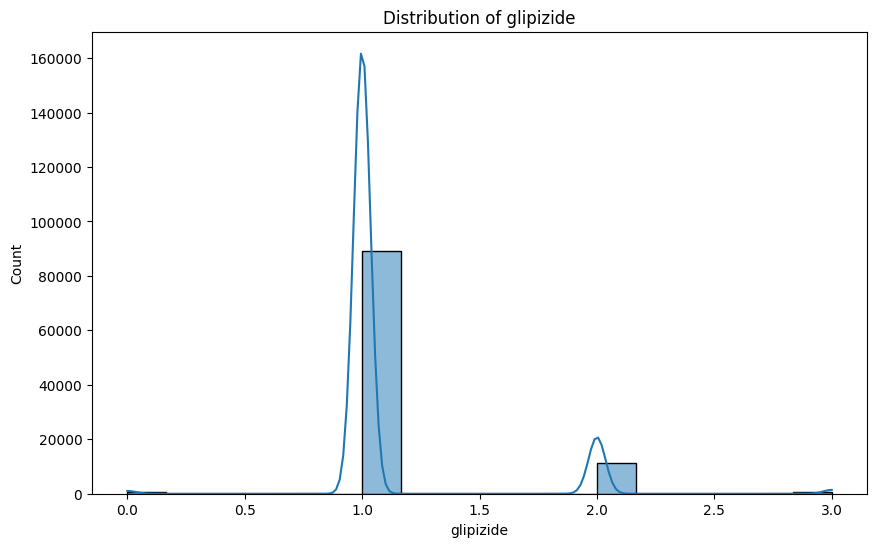

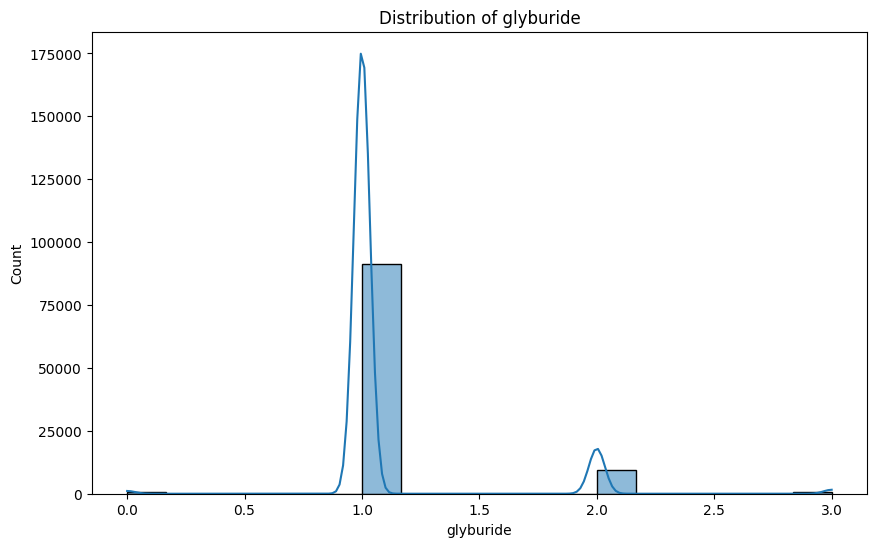

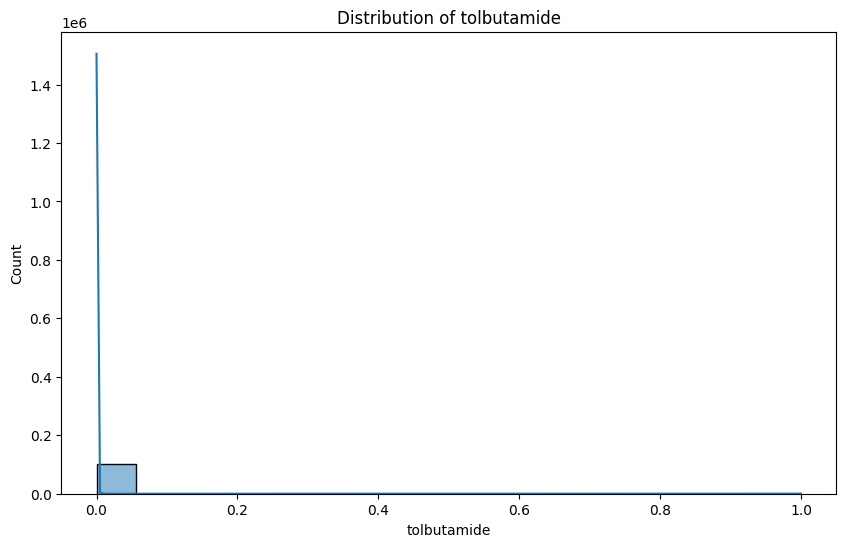

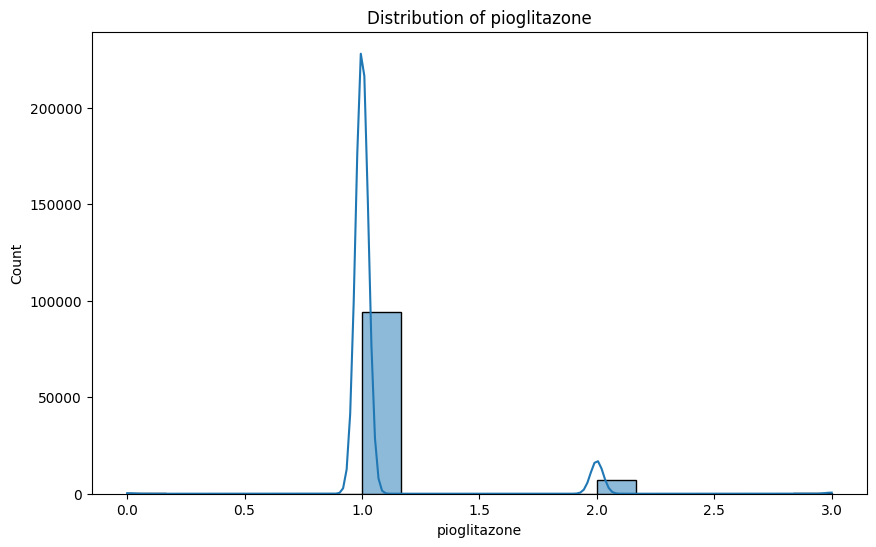

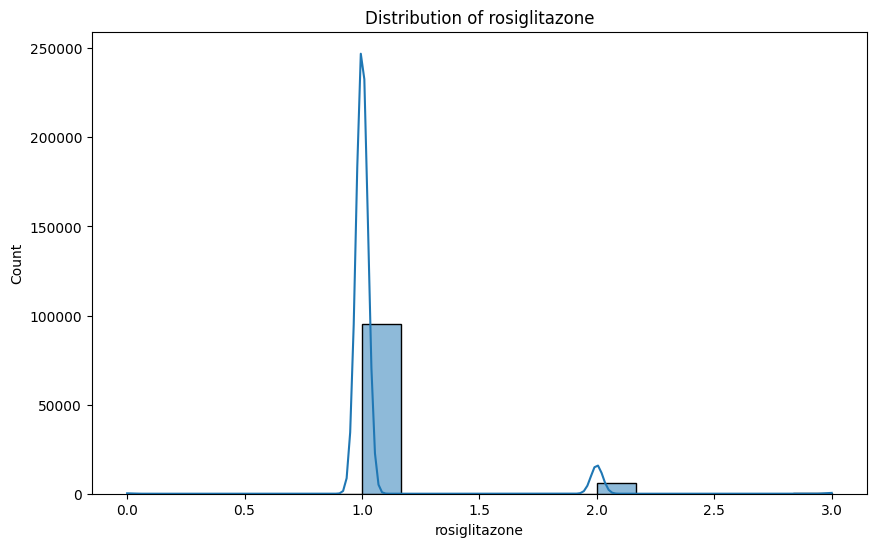

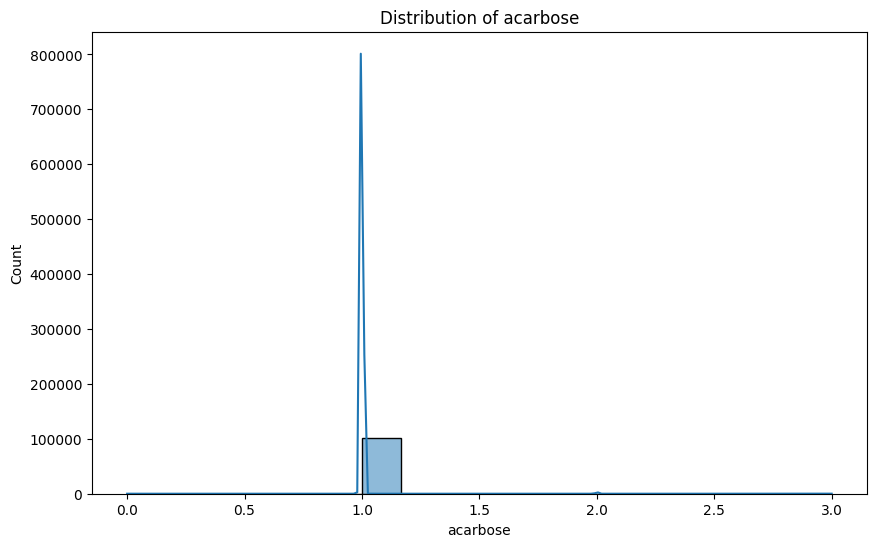

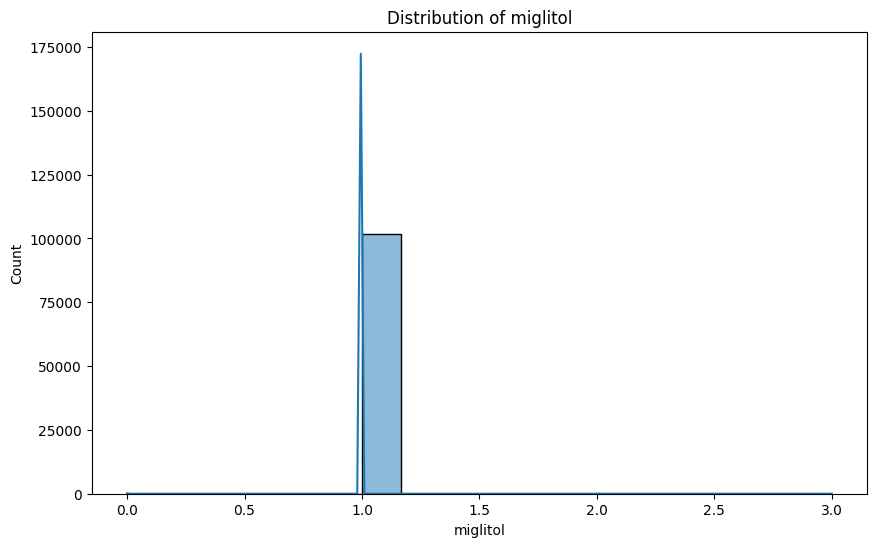

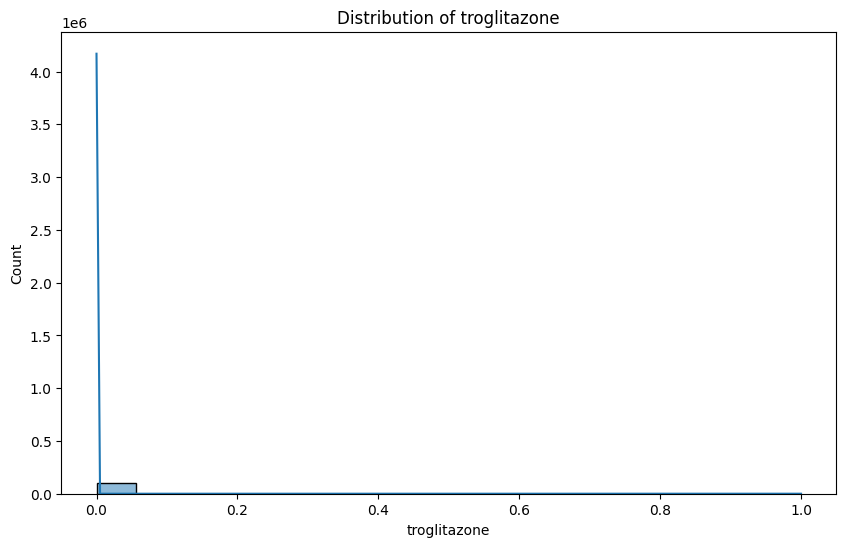

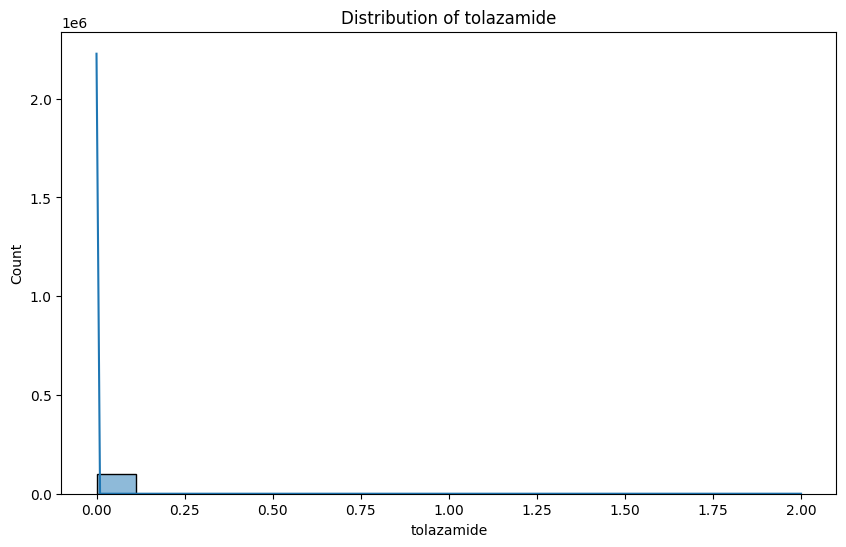

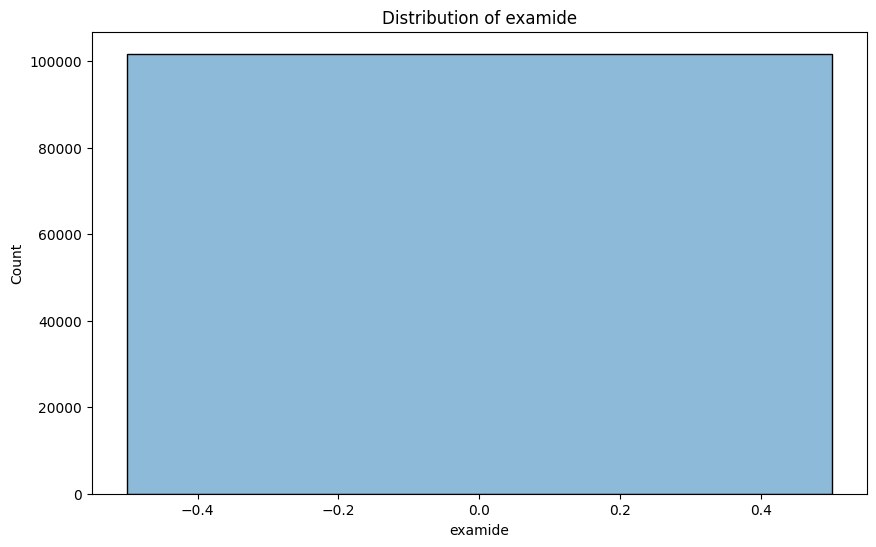

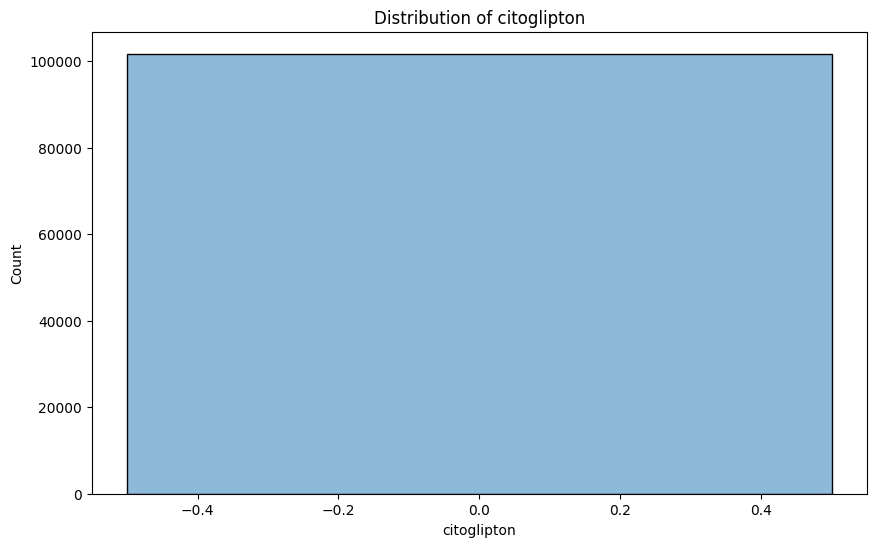

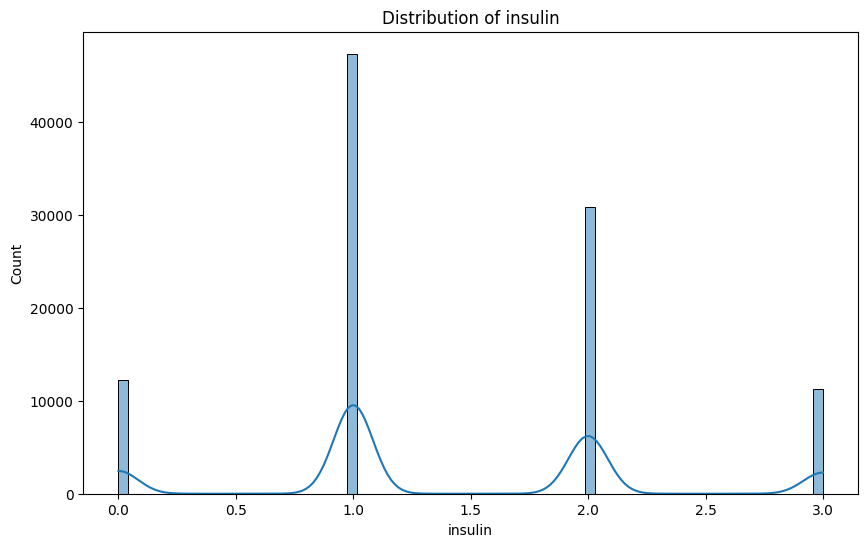

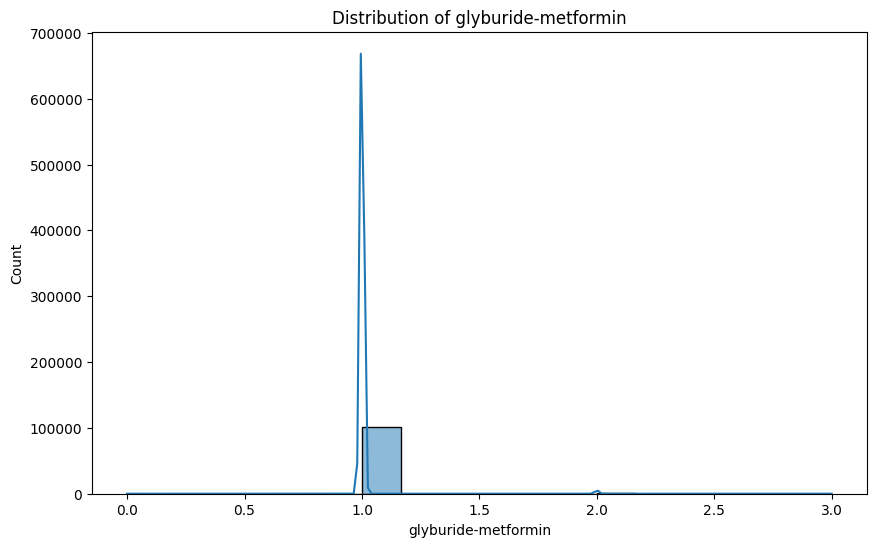

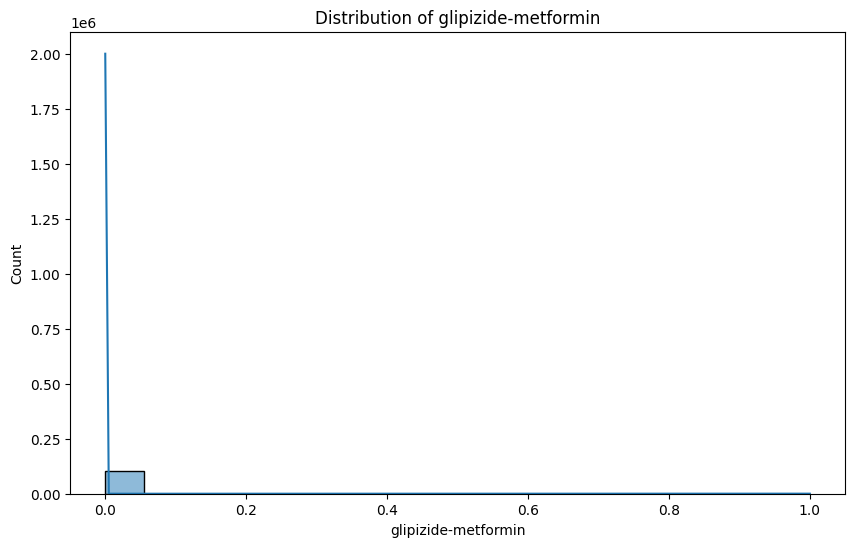

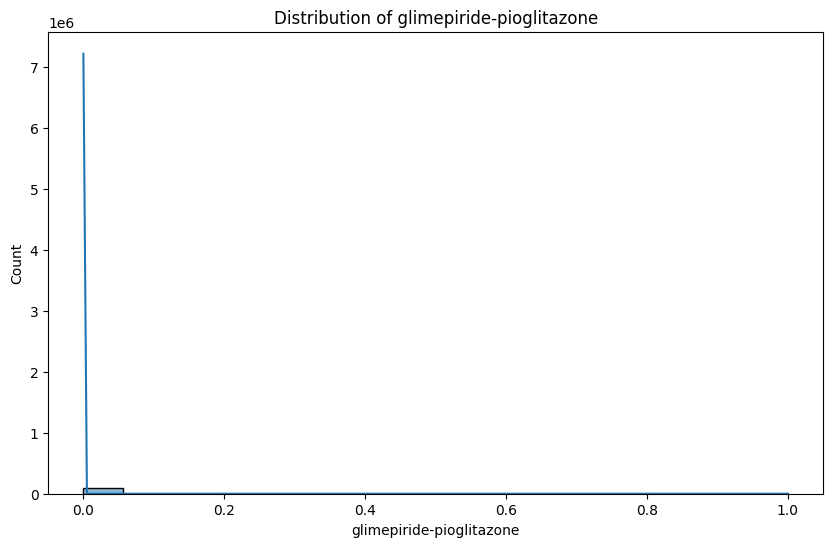

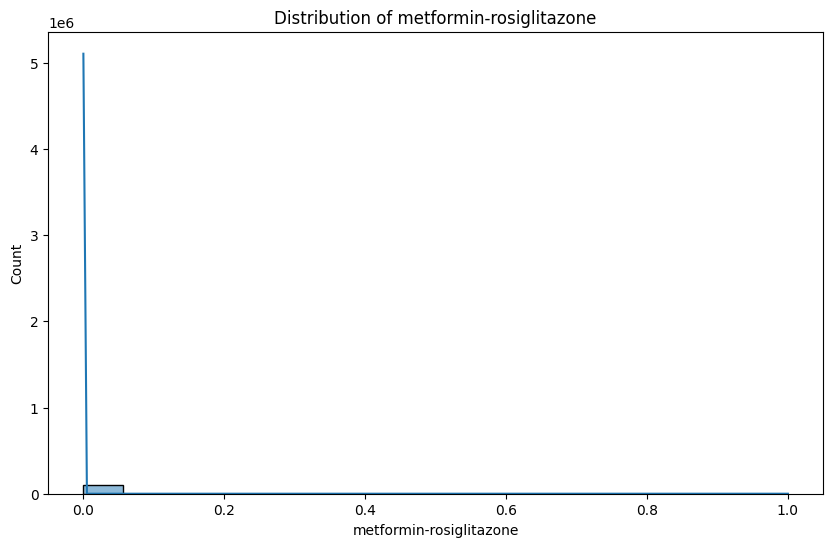

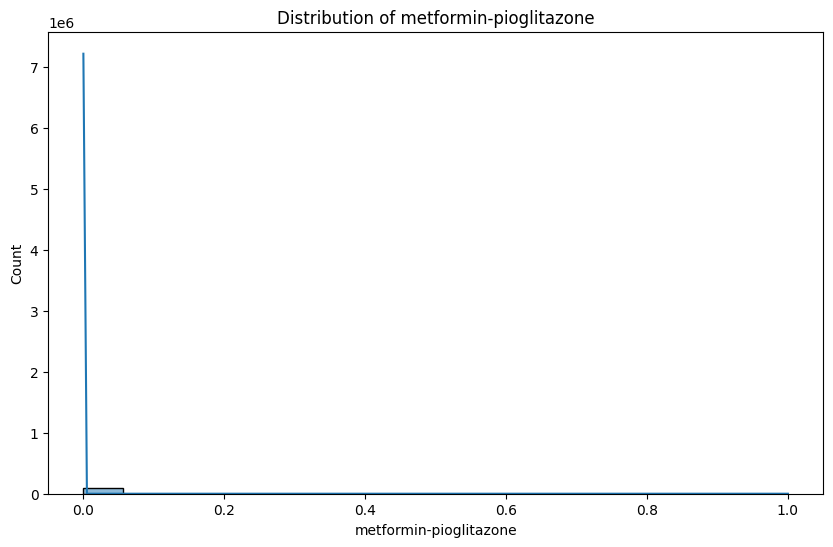

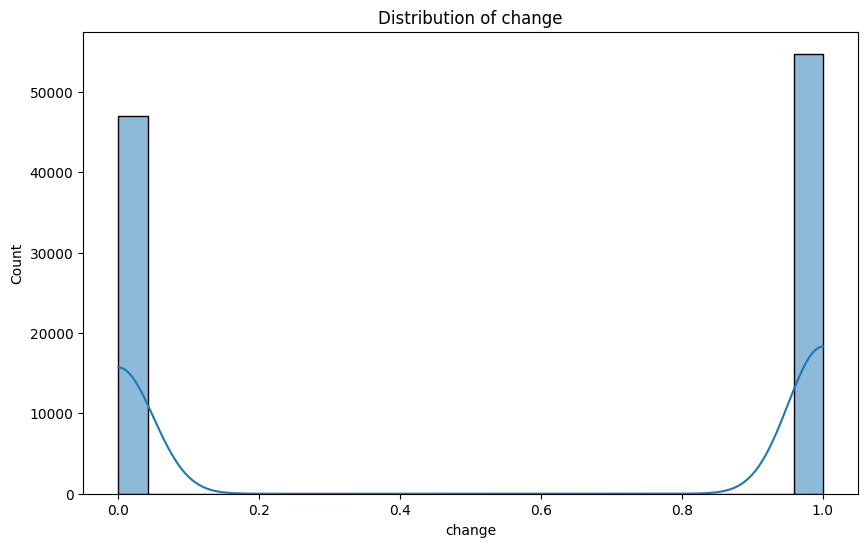

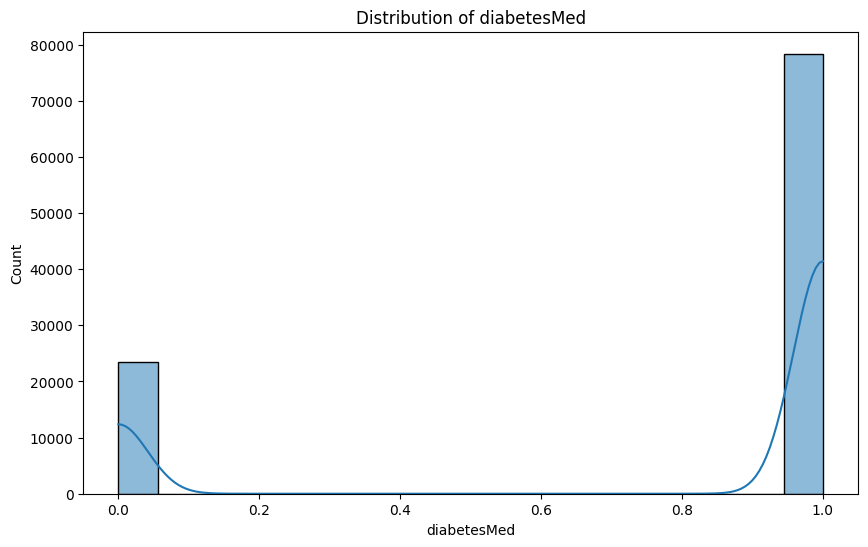

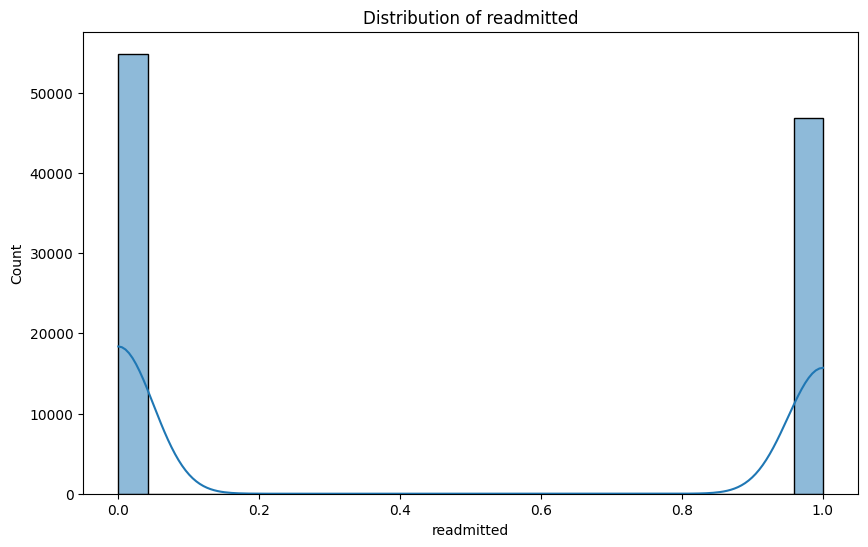

In [ ]:
# Univariate analysis
for col in df.columns:
    if df[col].dtype != 'object':
        plt.figure(figsize=(10, 6))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()
    else:
        plt.figure(figsize=(10, 6))
        df[col].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {col}')
        plt.show()

In [ ]:
#Bivariate analysis
#sns.pairplot(df[selected_features + ['readmitted']], hue='readmitted')
#plt.show()

C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Hp\AppData\Local\Temp\ipykernel_1312\4090314964.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 2000x2000 with 0 Axes>

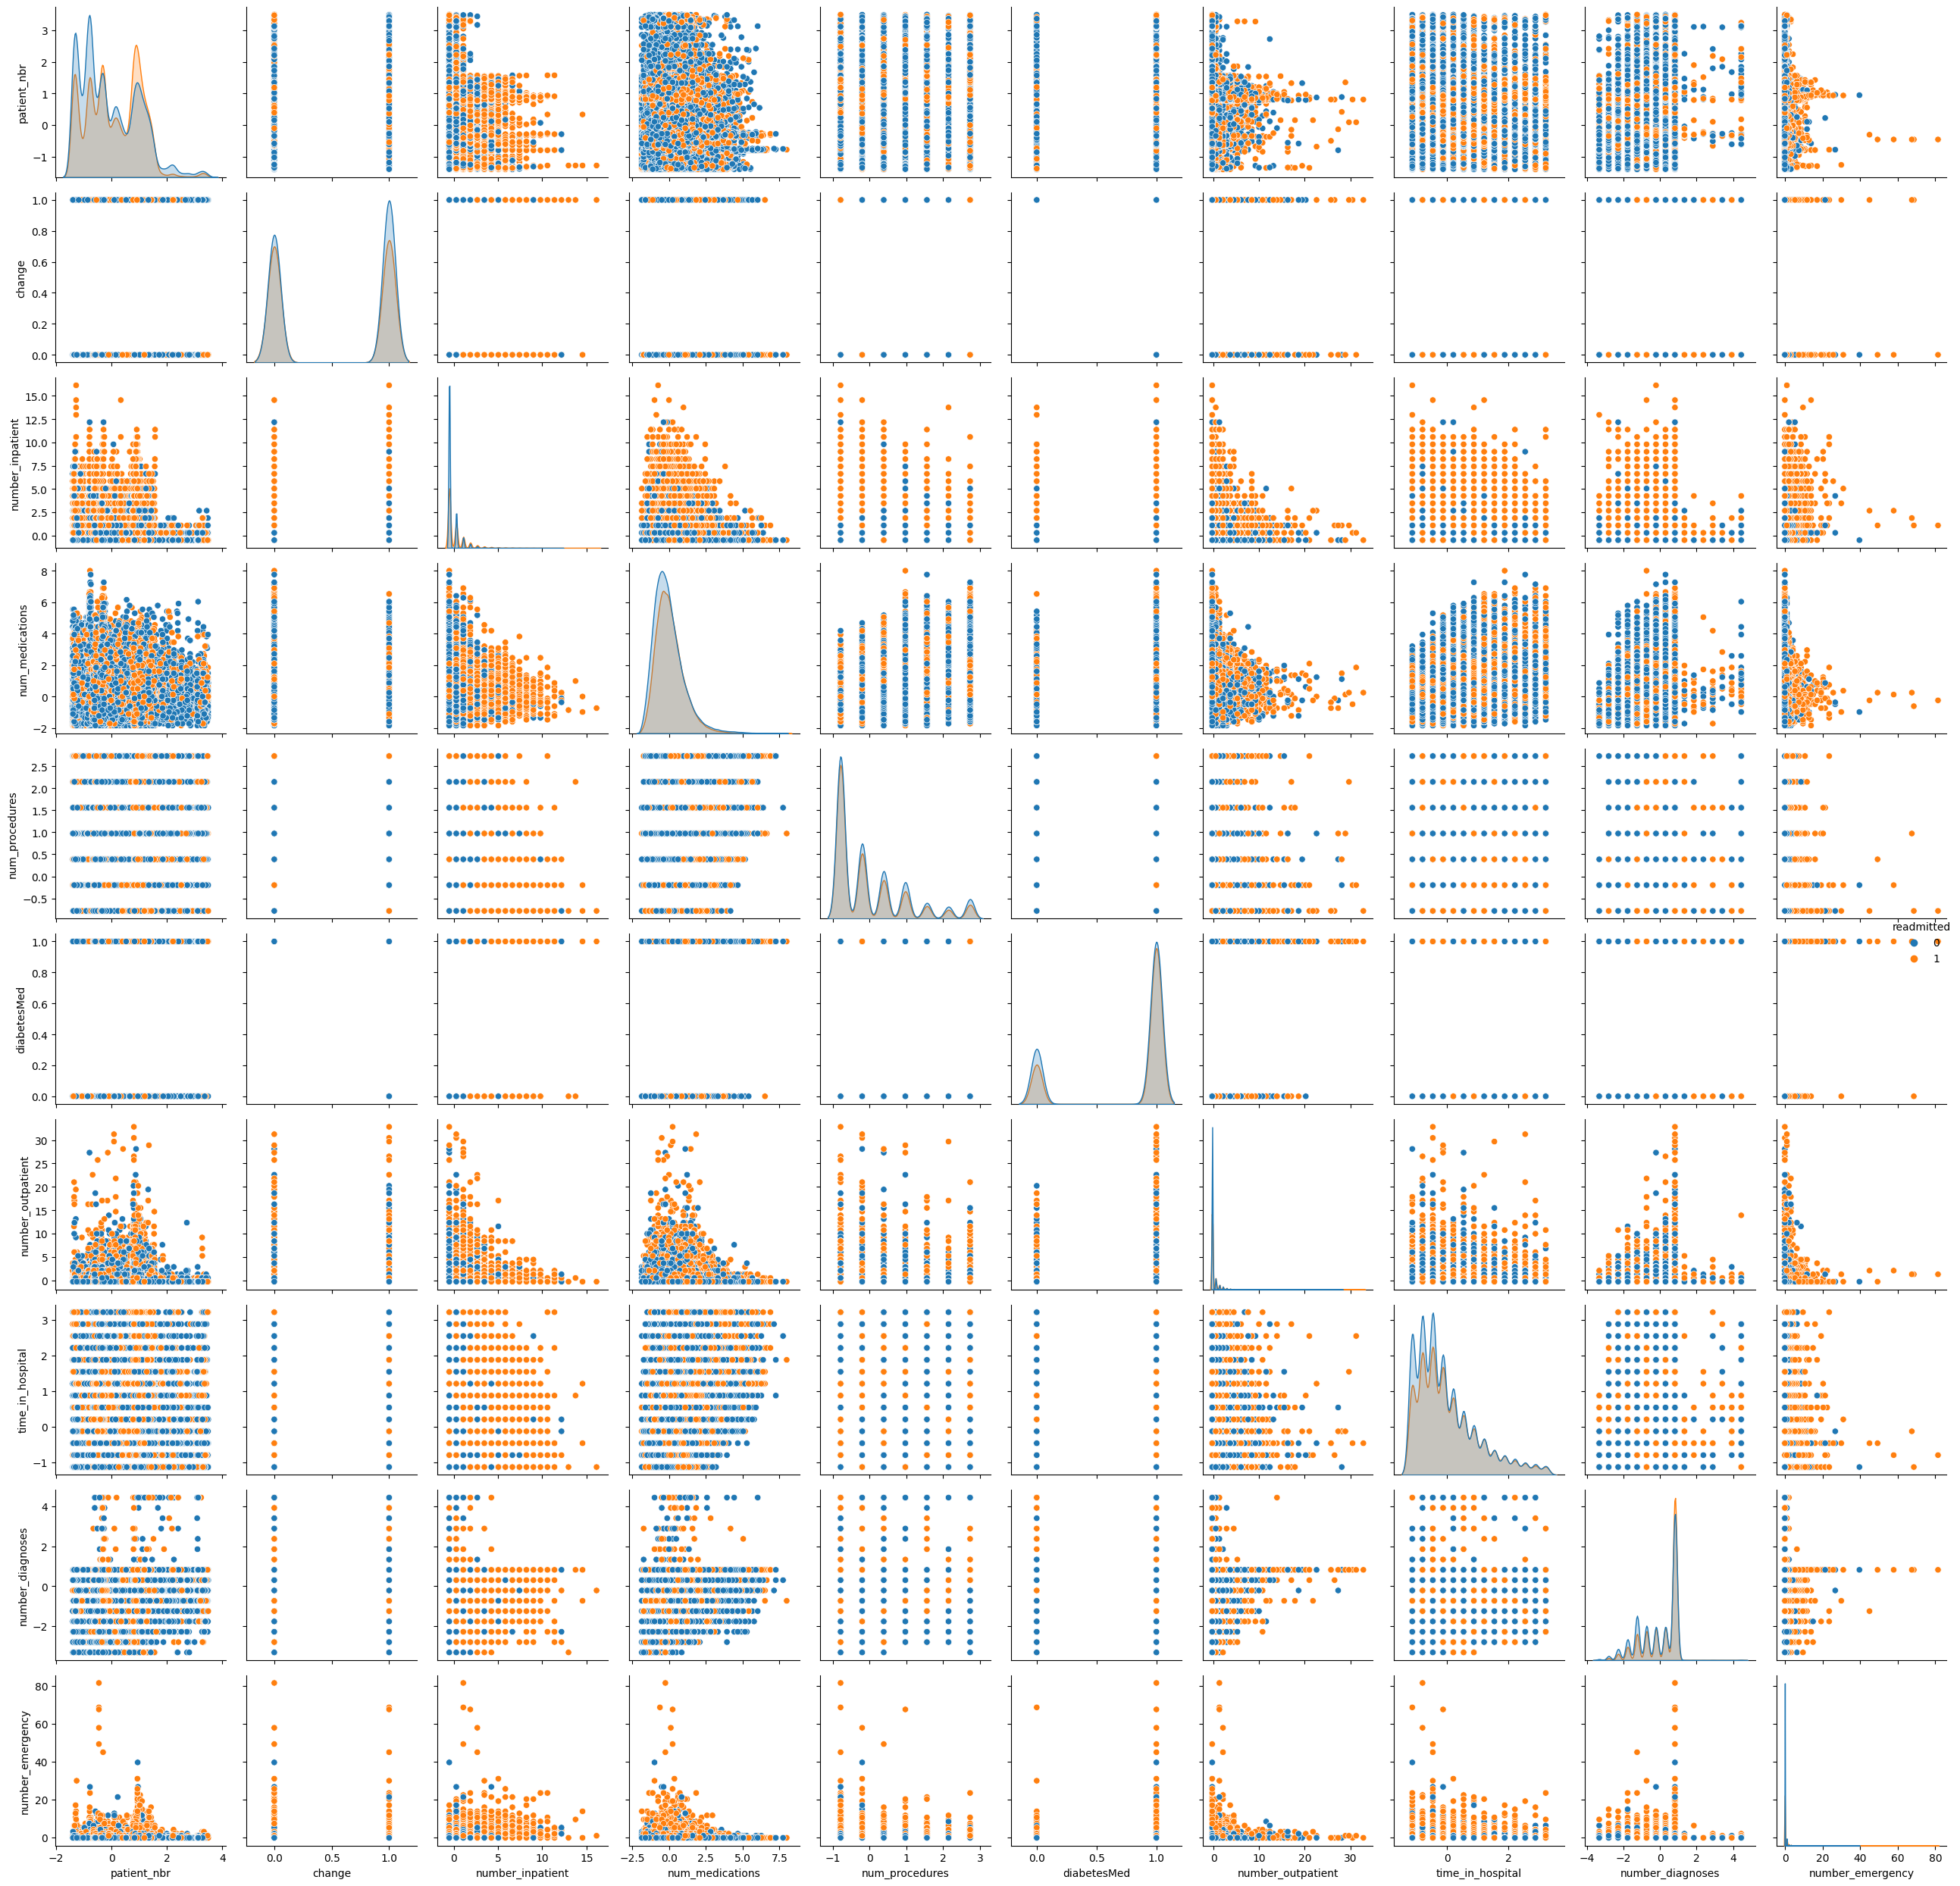

In [ ]:
# Bivariate analysis

features_to_plot = selected_features + ['readmitted']

features_to_plot = list(set(features_to_plot))
features_to_plot = [f for f in features_to_plot if f in df.columns]

plt.figure(figsize=(20, 20))
sns.pairplot(df[features_to_plot], hue='readmitted', height=2.5)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel

rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
rf_selector = rf_selector.fit(X, y)
selected_features_rf = X.columns[rf_selector.get_support()].tolist()
print("Selected features using Random Forest:", selected_features_rf)

Selected features using Random Forest: ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'glipizide', 'insulin', 'change']


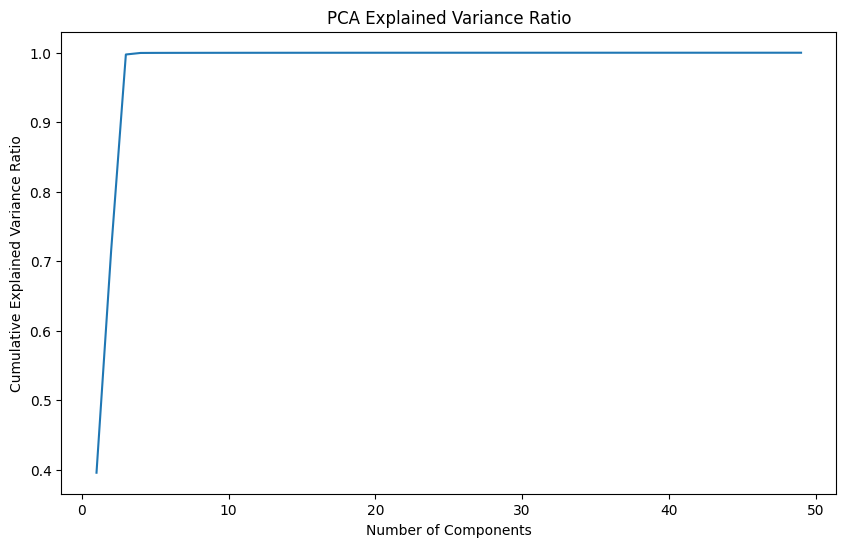

In [ ]:
pca = PCA()
X_pca_full = pca.fit_transform(X)
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.show()

C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


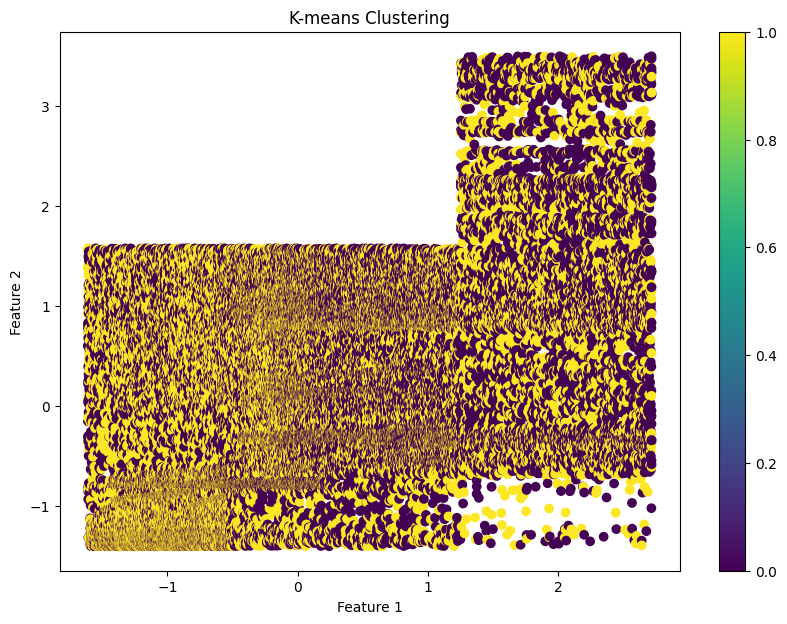

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df['Cluster'] = clusters

plt.figure(figsize=(10, 7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

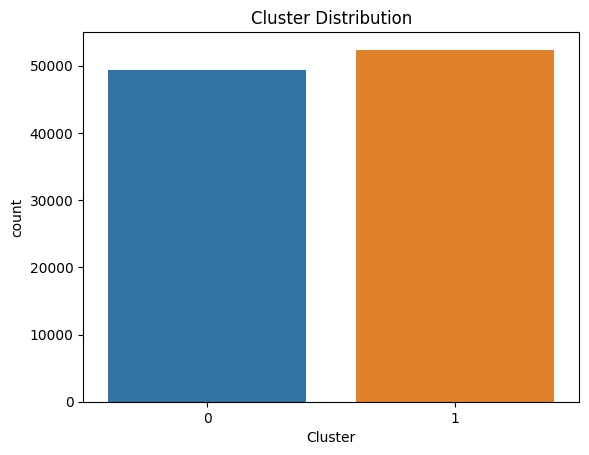

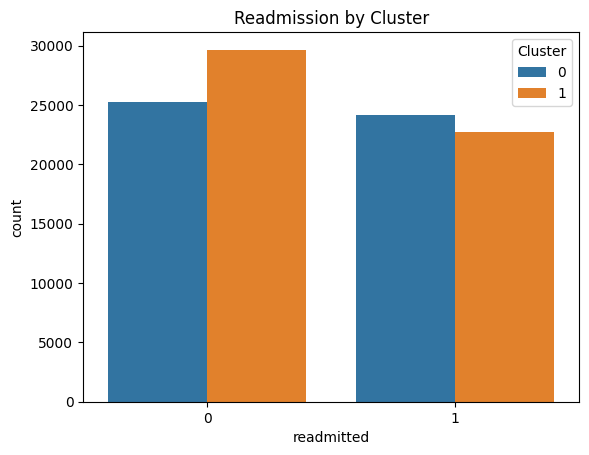

In [ ]:
import seaborn as sns

sns.countplot(x='Cluster', data=df)
plt.title('Cluster Distribution')
plt.show()

sns.countplot(x='readmitted', hue='Cluster', data=df)
plt.title('Readmission by Cluster')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [ ]:
X_train_original, X_test_original, y_train, y_test = train_test_split(X_original, y, test_size=0.2, random_state=42)

In [ ]:
imputer = SimpleImputer(strategy='mean')
X_train_original_imputed = imputer.fit_transform(X_train_original)
X_test_original_imputed = imputer.transform(X_test_original)

In [ ]:
knn_model_original = KNeighborsClassifier(n_neighbors=2)  # You can choose the number of neighbors (k) as needed
knn_model_original.fit(X_train_original_imputed, y_train)

KNeighborsClassifier(n_neighbors=2)

In [ ]:
y_pred_original = knn_model_original.predict(X_test_original_imputed)
print(classification_report(y_test, y_pred_original))

              precision    recall  f1-score   support

           0       0.56      0.80      0.66     10952
           1       0.53      0.26      0.35      9402

    accuracy                           0.55     20354
   macro avg       0.54      0.53      0.50     20354
weighted avg       0.54      0.55      0.51     20354



C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


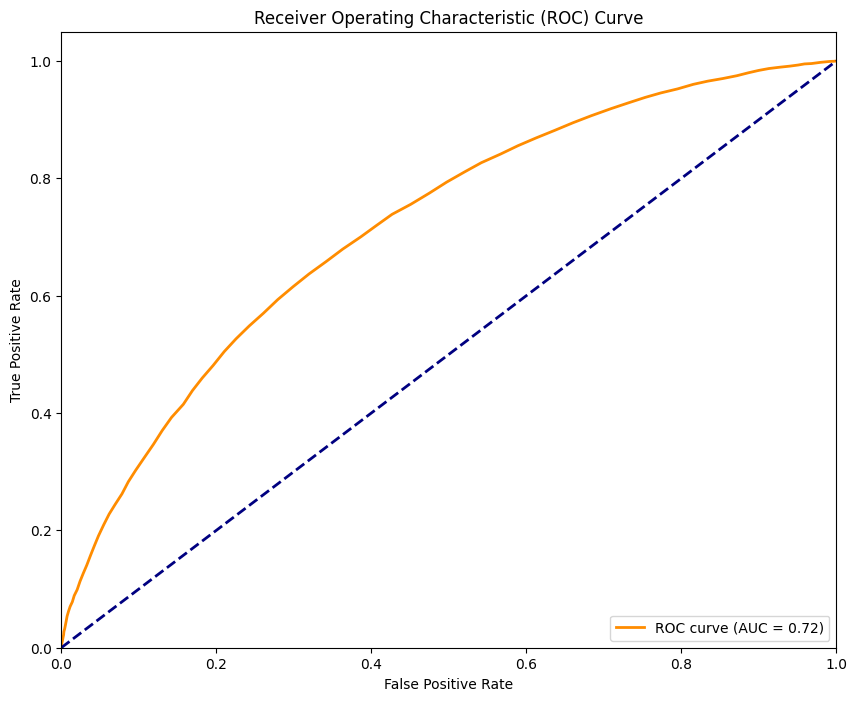

AUC Score: 0.7182


In [ ]:
# ROC AUC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = rf_model_original.predict_proba(X_test_original_imputed)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_original_imputed, y_train)
knn_pred = knn_model.predict(X_test_original_imputed)
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_auc = roc_auc_score(y_test, knn_model.predict_proba(X_test_original_imputed)[:, 1])

print("KNN Classification Report:")
print(classification_report(y_test, knn_pred))
print(f"KNN Accuracy: {knn_accuracy:.4f}")
print(f"KNN AUC: {knn_auc:.4f}")

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.60      0.59     10952
           1       0.51      0.48      0.49      9402

    accuracy                           0.55     20354
   macro avg       0.54      0.54      0.54     20354
weighted avg       0.54      0.55      0.54     20354

KNN Accuracy: 0.5461
KNN AUC: 0.5528


In [ ]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_original_imputed, y_train)
lr_pred = lr_model.predict(X_test_original_imputed)
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test_original_imputed)[:, 1])

print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred))
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Logistic Regression AUC: {lr_auc:.4f}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.78      0.69     10952
           1       0.64      0.45      0.53      9402

    accuracy                           0.63     20354
   macro avg       0.63      0.61      0.61     20354
weighted avg       0.63      0.63      0.62     20354

Logistic Regression Accuracy: 0.6272
Logistic Regression AUC: 0.6696


C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_original_imputed, y_train)
rf_pred = rf_model.predict(X_test_original_imputed)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test_original_imputed)[:, 1])

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest AUC: {rf_auc:.4f}")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.74      0.70     10952
           1       0.65      0.57      0.61      9402

    accuracy                           0.66     20354
   macro avg       0.66      0.65      0.65     20354
weighted avg       0.66      0.66      0.66     20354

Random Forest Accuracy: 0.6611
Random Forest AUC: 0.7182


In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_original_imputed, y_train)
dt_pred = dt_model.predict(X_test_original_imputed)
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_auc = roc_auc_score(y_test, dt_model.predict_proba(X_test_original_imputed)[:, 1])

print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_pred))
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Decision Tree AUC: {dt_auc:.4f}")

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.61      0.61     10952
           1       0.55      0.56      0.55      9402

    accuracy                           0.58     20354
   macro avg       0.58      0.58      0.58     20354
weighted avg       0.58      0.58      0.58     20354

Decision Tree Accuracy: 0.5833
Decision Tree AUC: 0.5814


In [ ]:
gbm_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbm_model.fit(X_train_original_imputed, y_train)
gbm_pred = gbm_model.predict(X_test_original_imputed)
gbm_accuracy = accuracy_score(y_test, gbm_pred)
gbm_auc = roc_auc_score(y_test, gbm_model.predict_proba(X_test_original_imputed)[:, 1])

print("GBM Classification Report:")
print(classification_report(y_test, gbm_pred))
print(f"GBM Accuracy: {gbm_accuracy:.4f}")
print(f"GBM AUC: {gbm_auc:.4f}")

GBM Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70     10952
           1       0.65      0.58      0.61      9402

    accuracy                           0.66     20354
   macro avg       0.66      0.66      0.66     20354
weighted avg       0.66      0.66      0.66     20354

GBM Accuracy: 0.6632
GBM AUC: 0.7218


In [ ]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_original_imputed, y_train)
xgb_pred = xgb_model.predict(X_test_original_imputed)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test_original_imputed)[:, 1])

print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f"XGBoost AUC: {xgb_auc:.4f}")

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70     10952
           1       0.65      0.62      0.63      9402

    accuracy                           0.67     20354
   macro avg       0.67      0.67      0.67     20354
weighted avg       0.67      0.67      0.67     20354

XGBoost Accuracy: 0.6685
XGBoost AUC: 0.7304


In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train_original_imputed, y_train)
nb_pred = nb_model.predict(X_test_original_imputed)
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_auc = roc_auc_score(y_test, nb_model.predict_proba(X_test_original_imputed)[:, 1])

print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_pred))
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print(f"Naive Bayes AUC: {nb_auc:.4f}")

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.89      0.70     10952
           1       0.65      0.23      0.35      9402

    accuracy                           0.59     20354
   macro avg       0.62      0.56      0.52     20354
weighted avg       0.61      0.59      0.54     20354

Naive Bayes Accuracy: 0.5894
Naive Bayes AUC: 0.6452


In [ ]:
voting_model = VotingClassifier(
    estimators=[('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
                ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
                ('lr', LogisticRegression(random_state=42))],
    voting='soft'
)
voting_model.fit(X_train_original_imputed, y_train)
voting_pred = voting_model.predict(X_test_original_imputed)
voting_accuracy = accuracy_score(y_test, voting_pred)
voting_auc = roc_auc_score(y_test, voting_model.predict_proba(X_test_original_imputed)[:, 1])

print("Voting Classifier Classification Report:")
print(classification_report(y_test, voting_pred))
print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")
print(f"Voting Classifier AUC: {voting_auc:.4f}")

C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.76      0.71     10952
           1       0.66      0.55      0.60      9402

    accuracy                           0.66     20354
   macro avg       0.66      0.65      0.65     20354
weighted avg       0.66      0.66      0.66     20354

Voting Classifier Accuracy: 0.6620
Voting Classifier AUC: 0.7195


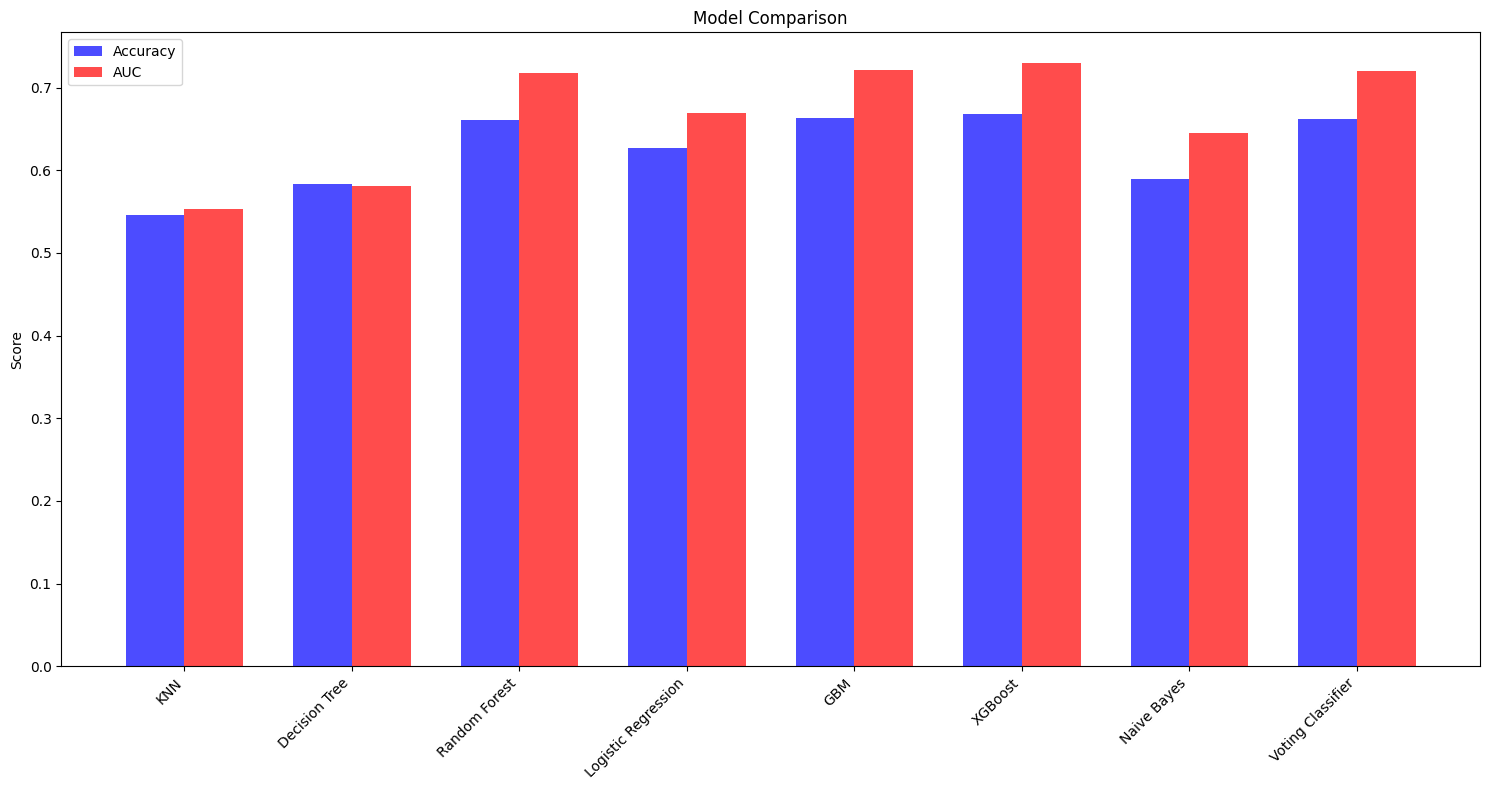

In [ ]:
models = ['KNN', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'GBM', 'XGBoost', 'Naive Bayes', 'Voting Classifier']
accuracies = [knn_accuracy, dt_accuracy, rf_accuracy, lr_accuracy, gbm_accuracy, xgb_accuracy, nb_accuracy, voting_accuracy]
aucs = [knn_auc, dt_auc, rf_auc, lr_auc, gbm_auc, xgb_auc, nb_auc, voting_auc]

plt.figure(figsize=(15, 8))
x = range(len(models))
width = 0.35

plt.bar([i - width/2 for i in x], accuracies, width, label='Accuracy', color='blue', alpha=0.7)
plt.bar([i + width/2 for i in x], aucs, width, label='AUC', color='red', alpha=0.7)

plt.ylabel('Score')
plt.title('Model Comparison')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("\nModel Comparison:")
print("-----------------")
print("Model               Accuracy    AUC")
print("-----------------   --------    ---")
print(f"KNN                 {knn_accuracy:.4f}    {knn_auc:.4f}")
print(f"Decision Tree       {dt_accuracy:.4f}    {dt_auc:.4f}")
print(f"Random Forest       {rf_accuracy:.4f}    {rf_auc:.4f}")
print(f"Logistic Regression {lr_accuracy:.4f}    {lr_auc:.4f}")
print(f"GBM                 {gbm_accuracy:.4f}    {gbm_auc:.4f}")
print(f"XGBoost             {xgb_accuracy:.4f}    {xgb_auc:.4f}")
print(f"Naive Bayes         {nb_accuracy:.4f}    {nb_auc:.4f}")
print(f"Voting Classifier   {voting_accuracy:.4f}    {voting_auc:.4f}")


Model Comparison:
-----------------
Model               Accuracy    AUC
-----------------   --------    ---
KNN                 0.5461    0.5528
Decision Tree       0.5833    0.5814
Random Forest       0.6611    0.7182
Logistic Regression 0.6272    0.6696
GBM                 0.6632    0.7218
XGBoost             0.6685    0.7304
Naive Bayes         0.5894    0.6452
Voting Classifier   0.6620    0.7195


C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-means Clustering Results:
Accuracy (cluster labels as predictions): 0.5208
Silhouette Score: 0.3164


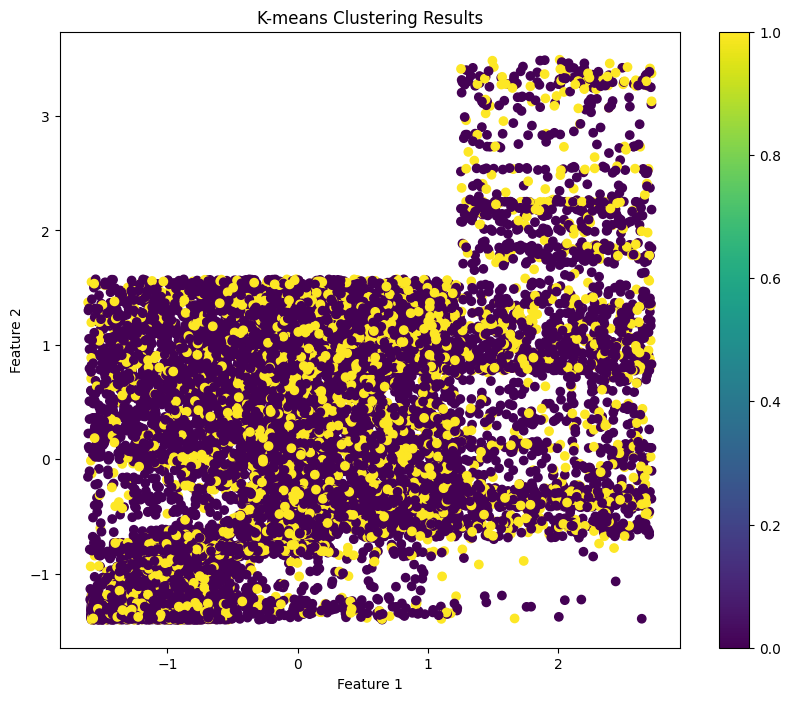

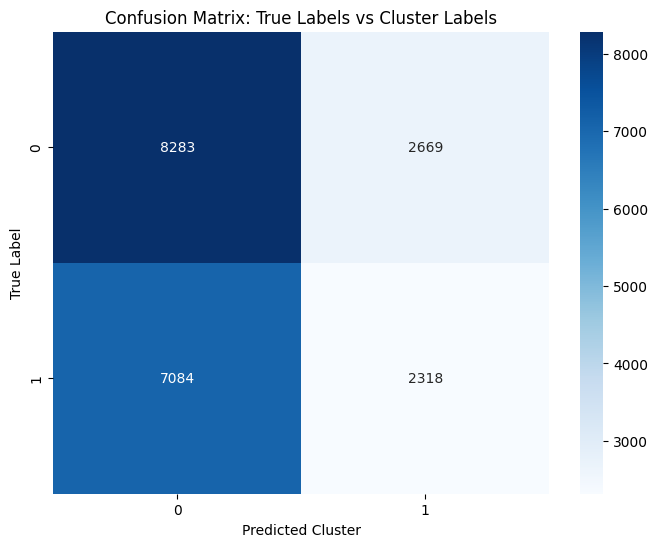

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)  # Using 2 clusters as we have binary classification
kmeans.fit(X_train_original_imputed)

kmeans_pred = kmeans.predict(X_test_original_imputed)

kmeans_accuracy = accuracy_score(y_test, kmeans_pred)

silhouette_avg = silhouette_score(X_test_original_imputed, kmeans_pred)

print("K-means Clustering Results:")
print(f"Accuracy (cluster labels as predictions): {kmeans_accuracy:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

if X_test_original_imputed.shape[1] >= 2:
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_test_original_imputed[:, 0], X_test_original_imputed[:, 1],
                          c=kmeans_pred, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('K-means Clustering Results')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

cm = confusion_matrix(y_test, kmeans_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: True Labels vs Cluster Labels')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.show()

In [ ]:
results_df = pd.DataFrame({
    'True_Label': y_test,
    'KNN_Pred': knn_pred,
    'DecisionTree_Pred': dt_pred,
    'RandomForest_Pred': rf_pred,
    'LogisticRegression_Pred': lr_pred,
    'GBM_Pred': gbm_pred,
    'XGBoost_Pred': xgb_pred,
    'NaiveBayes_Pred': nb_pred,
    'VotingClassifier_Pred': voting_pred
})

results_df.to_excel('model_predictions.xlsx', index=False)

print("Results saved to 'model_predictions.xlsx'")

Results saved to 'model_predictions.xlsx'


# Test Dataset

In [ ]:
import joblib
joblib.dump(rf_pred, 'readmission_model_reloaded.joblib')

print("Model re-saved successfully.")

Model re-saved successfully.


In [ ]:
model = joblib.load('readmission_model_reloaded.joblib')

In [ ]:
'''test_data = pd.DataFrame({
    'encounter_id': np.random.randint(1000000, 2000000, 10),
    'patient_nbr': np.random.randint(1000000, 2000000, 10),
    'race': np.random.choice(['Caucasian', 'AfricanAmerican', 'Asian', 'Hispanic', 'Other'], 10),
    'gender': np.random.choice(['Female', 'Male'], 10),
    'age': np.random.choice(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'], 10),
    'weight': np.random.choice(['[0-25)', '[25-50)', '[50-75)', '[75-100)', '[100-125)', '[125-150)', '[150-175)', '[175-200)'], 10),
    'admission_type_id': np.random.randint(1, 9, 10),
    'discharge_disposition_id': np.random.randint(1, 30, 10),
    'admission_source_id': np.random.randint(1, 26, 10),
    'time_in_hospital': np.random.randint(1, 15, 10),
    'payer_code': np.random.choice(['CP', 'MC', 'MD', 'HM', 'SP', 'BC', 'UN', 'OT'], 10),
    'medical_specialty': np.random.choice(['InternalMedicine', 'Cardiology', 'Surgery', 'Oncology', 'Pediatrics', 'Emergency', 'Neurology', 'Orthopedics'], 10),
    'num_lab_procedures': np.random.randint(1, 100, 10),
    'num_procedures': np.random.randint(0, 10, 10),
    'num_medications': np.random.randint(1, 50, 10),
    'number_outpatient': np.random.randint(0, 10, 10),
    'number_emergency': np.random.randint(0, 5, 10),
    'number_inpatient': np.random.randint(0, 5, 10),
    'diag_1': np.random.randint(1, 1000, 10).astype(str),
    'diag_2': np.random.randint(1, 1000, 10).astype(str),
    'diag_3': np.random.randint(1, 1000, 10).astype(str),
    'number_diagnoses': np.random.randint(1, 15, 10),
    'max_glu_serum': np.random.choice(['None', '>200', '>300', 'Norm'], 10),
    'A1Cresult': np.random.choice(['None', '>7', '>8', 'Norm'], 10),
    'metformin': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'repaglinide': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'nateglinide': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'chlorpropamide': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'glimepiride': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'acetohexamide': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'glipizide': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'glyburide': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'tolbutamide': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'pioglitazone': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'rosiglitazone': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'acarbose': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'miglitol': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'troglitazone': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'tolazamide': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'examide': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'citoglipton': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'insulin': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'glyburide-metformin': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'glipizide-metformin': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'glimepiride-pioglitazone': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'metformin-rosiglitazone': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'metformin-pioglitazone': np.random.choice(['No', 'Steady', 'Up', 'Down'], 10),
    'change': np.random.choice(['No', 'Ch'], 10),
    'diabetesMed': np.random.choice(['Yes', 'No'], 10),
    'readmitted': np.random.choice(['<30', '>30', 'NO'], 10),
    'email': [f'patient{i}@example.com' for i in range(1, 11)],
    'name': [f'Patient {i}' for i in range(1, 11)]
})
'''

In [ ]:
'''csv_file = 'test_data.csv'

# Save the DataFrame to CSV
test_data.to_csv(csv_file, index=False)

print(f"Data saved to {csv_file}")'''

Data saved to test_data.csv


In [ ]:
test_data = pd.read_csv("test_data.csv")

In [ ]:
test_data

encounter_id  patient_nbr             race  gender       age     weight  \
0       1717953      1074370            Other  Female   [50-60)  [175-200)   
1       1916811      1628101  AfricanAmerican    Male   [10-20)   [75-100)   
2       1830227      1260822  AfricanAmerican  Female    [0-10)    [25-50)   
3       1422657      1658735            Asian  Female    [0-10)   [75-100)   
4       1297514      1951315         Hispanic    Male   [40-50)  [100-125)   
5       1371514      1217972         Hispanic    Male   [40-50)    [25-50)   
6       1544737      1238282            Other    Male    [0-10)    [50-75)   
7       1601629      1912629  AfricanAmerican    Male  [90-100)     [0-25)   
8       1523565      1134214            Asian    Male   [50-60)  [150-175)   
9       1092454      1224434        Caucasian    Male   [10-20)   [75-100)   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  8                         7                   20   
1                  6                        18                    7   
2                  6                        17                    1   
3                  4                        29                   11   
4                  6                        17                   23   
5                  2                        17                    4   
6                  4                         2                   21   
7                  4                        25                   16   
8                  1                        16                    1   
9                  2                         8                    5   

   time_in_hospital  ... glipizide-metformin glimepiride-pioglitazone  \
0                 5  ...                  No                   Steady   
1                 1  ...                Down                       No   
2                 6  ...                Down                   Steady   
3                 9  ...                Down                       Up   
4                10  ...              Steady                   Steady   
5                14  ...                  No                   Steady   
6                 7  ...                  No                       Up   
7                 1  ...                  No                       No   
8                 2  ...              Steady                   Steady   
9                12  ...                Down                   Steady   

   metformin-rosiglitazone  metformin-pioglitazone  change  diabetesMed  \
0                   Steady                      No      No          Yes   
1                   Steady                      No      Ch          Yes   
2                     Down                      No      Ch           No   
3                       No                      Up      Ch           No   
4                       No                  Steady      Ch          Yes   
5                   Steady                      Up      No          Yes   
6                       No                  Steady      Ch           No   
7                     Down                  Steady      Ch          Yes   
8                   Steady                    Down      Ch          Yes   
9                   Steady                      Up      No           No   

   readmitted             email        name  readmission_risk  
0         >30  glycok@gmail.com   Patient 1                 0  
1         <30  glycok@gmail.com   Patient 2                 0  
2          NO  glycok@gmail.com   Patient 3                 1  
3         >30  glycok@gmail.com   Patient 4                 1  
4         >30  glycok@gmail.com   Patient 5                 1  
5         >30  glycok@gmail.com   Patient 6                 0  
6         >30  glycok@gmail.com   Patient 7                 1  
7          NO  glycok@gmail.com   Patient 8                 1  
8          NO  glycok@gmail.com   Patient 9                 0  
9          NO  glycok@gmail.com  Patient 10                 1  

[10 rows x 53 columns]

In [ ]:
import pandas as pd
import numpy as np
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import joblib

# Load the pre-computed predictions
model = joblib.load('readmission_model_reloaded.joblib')  # Adjust the filename as necessary

# Create a test dataset
test_data = pd.read_csv("test_data.csv")

# Use the pre-computed predictions
y_pred = model[:10]  # We only need the first 10 predictions for our test data

# Add predicted classes to the test dataframe
test_data['readmission_risk'] = y_pred

# Function to send email
def send_email(to_email, name):
    from_email = "the.one.perfect001@gmail.com"
    password = "mpsm rwtv bvbz wend"

    subject = "Important: Follow-up Checkup Required"
    body = f"Dear {name},\n\nOur records indicate that you may be at risk for hospital readmission. We kindly request that you schedule a follow-up checkup as soon as possible to ensure your continued health and well-being.\n\nPlease contact our office to arrange an appointment.\n\nBest regards,\nYour Healthcare Team"

    msg = MIMEMultipart()
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        server.login(from_email, password)
        text = msg.as_string()
        server.sendmail(from_email, to_email, text)
        server.quit()
        print(f"Email sent successfully to {name}")
    except Exception as e:
        print(f"Failed to send email to {name}. Error: {str(e)}")

# Send emails to patients with high readmission risk
high_risk_patients = test_data[test_data['readmission_risk'] == 1]  # Adjust this based on your model's output
for _, patient in high_risk_patients.iterrows():
    send_email(patient['email'], patient['name'])

print("Email automation process completed.")

Email sent successfully to Patient 3
Email sent successfully to Patient 4
Email sent successfully to Patient 5
Email sent successfully to Patient 7
Email sent successfully to Patient 8
Email sent successfully to Patient 10
Email automation process completed.
